# Laboratorio #4

**Esteban Zambrano - 22119**<br>
**Andrés Ortega - 22305**<br>
**Diego García - 22404**

In [ ]:
#!pip install openeo
#!pip install rasterio
#!pip install folium branca

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import openeo
import glob
import os
import re
import pandas as pd
import warnings
import seaborn as sns

from datetime import date
from pathlib import Path
from scipy.signal import find_peaks

In [8]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [3]:
#Areas de interes
lago_atitlan = {
    "west": -91.349,
    "east": -91.0702,
    "south": 14.5971,
    "north": 14.7648
}
lago_amatitlan = {
    "west": -90.66,
    "east": -90.58,
    "south": 14.43,
    "north": 14.51
}

bands_needed = ["B02","B03","B04","B05","B07","B08","B8A","B11","B12"]

In [4]:
# Código de https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/cyanobacteria_chla_ndci_l1c/#representative-images pasado a python

# Water body detection - credit Mohor Gartner
MNDWI_threshold = 0.42
NDWI_threshold = 0.4
filter_UABS = True
filter_SSI = False

def wbi(r, g, b, nir, swir1, swir2):
    # water surface
    ws = 0
    try:
        # Calc indices
        ndvi = (nir - r) / (nir + r)
        mndwi = (g - swir1) / (g + swir1)
        ndwi = (g - nir) / (g + nir)
        ndwi_leaves = (nir - swir1) / (nir + swir1)
        aweish = b + 2.5 * g - 1.5 * (nir + swir1) - 0.25 * swir2
        aweinsh = 4 * (g - swir1) - (0.25 * nir + 2.75 * swir1)

        dbsi = ((swir1 - g) / (swir1 + g)) - ndvi
        wii = np.power(nir, 2) / r
        wri = (g + r) / (nir + swir1)
        puwi = 5.83 * g - 6.57 * r - 30.32 * nir + 2.25
        uwi = (g - 1.1 * r - 5.2 * nir + 0.4) / np.abs(g - 1.1 * r - 5.2 * nir)
        usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1

        if (mndwi > MNDWI_threshold or ndwi > NDWI_threshold or
            aweinsh > 0.1879 or aweish > 0.1112 or
            ndvi < -0.2 or ndwi_leaves > 1):
            ws = 1

        if filter_UABS and ws == 1:
            if (aweinsh <= -0.03) or (dbsi > 0):
                ws = 0

    except Exception:
        ws = 0
    return ws

# Floating vegetation
def FAI(a, b, c):
    return b - a - (c - a) * (783 - 665) / (865 - 665)

# Chlorophyll-a
def NDCI(a, b):
    return (b - a) / (b + a)

def classify_pixel(B02, B03, B04, B05, B07, B08, B8A, B11, B12):
    water = wbi(B04, B03, B02, B08, B11, B12)
    FAIv = FAI(B04, B07, B8A)
    NDCIv = NDCI(B04, B05)
    chl = 826.57 * NDCIv**3 - 176.43 * NDCIv**2 + 19 * NDCIv + 4.071

    trueColor = [3 * B04, 3 * B03, 3 * B02]

    #  Render colour map
    if water == 0:
        return trueColor
    elif FAIv > 0.08:
        return [233/255, 72/255, 21/255]
    elif chl < 0.5:
        return [0, 0, 1.0]
    elif chl < 1:
        return [0, 0, 1.0]
    elif chl < 2.5:
        return [0, 59/255, 1]
    elif chl < 3.5:
        return [0, 98/255, 1]
    elif chl < 5:
        return [15/255, 113/255, 141/255]
    elif chl < 7:
        return [14/255, 141/255, 120/255]
    elif chl < 8:
        return [13/255, 141/255, 103/255]
    elif chl < 10:
        return [30/255, 226/255, 28/255]
    elif chl < 14:
        return [42/255, 226/255, 28/255]
    elif chl < 18:
        return [68/255, 226/255, 28/255]
    elif chl < 20:
        return [68/255, 226/255, 28/255]
    elif chl < 24:
        return [134/255, 247/255, 0]
    elif chl < 28:
        return [140/255, 247/255, 0]
    elif chl < 30:
        return [205/255, 237/255, 0]
    elif chl < 38:
        return [208/255, 240/255, 0]
    elif chl < 45:
        return [208/255, 240/255, 0]
    elif chl < 50:
        return [251/255, 210/255, 3/255]
    elif chl < 75:
        return [248/255, 207/255, 2/255]
    elif chl < 90:
        return [134/255, 247/255, 0]
    elif chl < 100:
        return [245/255, 164/255, 9/255]
    elif chl < 150:
        return [240/255, 159/255, 8/255]
    elif chl < 250:
        return [237/255, 157/255, 7/255]
    elif chl < 300:
        return [239/255, 118/255, 15/255]
    elif chl < 350:
        return [239/255, 101/255, 15/255]
    elif chl < 450:
        return [239/255, 100/255, 14/255]
    elif chl < 500:
        return [233/255, 72/255, 21/255]
    else:
        return [233/255, 72/255, 21/255]

In [5]:
def download_lake(spatial_extent, output_path):
    cube = connection.load_collection(
        "SENTINEL2_L2A",
        spatial_extent=spatial_extent,
        temporal_extent=["2025-02-01", "2025-07-31"],
        bands=bands_needed,
        max_cloud_cover=20
    )
    
    # Guardar resultado temporal en GeoTIFF
    temp_result = cube.save_result(format="GTIFF")
    job = connection.create_job(temp_result)
    job.start_and_wait()
    job.download_results(output_path)


def process_image(input_tif, output_tif):
    with rasterio.open(input_tif) as src:
        bands_data = src.read()
        transform = src.transform
        crs = src.crs
    
    # Extraer bandas por nombre
    B02, B03, B04, B05, B07, B08, B8A, B11, B12 = bands_data
    
    # Salida con 3 canales RGB
    rgb = np.zeros((3, B02.shape[0], B02.shape[1]), dtype=np.float32)
    
    for i in range(B02.shape[0]):
        for j in range(B02.shape[1]):
            rgb_pixel = classify_pixel(
                B02[i, j], B03[i, j], B04[i, j], B05[i, j],
                B07[i, j], B08[i, j], B8A[i, j], B11[i, j], B12[i, j]
            )
            rgb[:, i, j] = rgb_pixel
    
    # Guardar resultado
    with rasterio.open(
        output_tif,
        "w",
        driver="GTiff",
        height=rgb.shape[1],
        width=rgb.shape[2],
        count=3,
        dtype=rgb.dtype,
        crs=crs,
        transform=transform
    ) as dst:
        dst.write(rgb[0], 1)
        dst.write(rgb[1], 2)
        dst.write(rgb[2], 3)

In [13]:
# Descargar imagenes de los lagos

# download_lake(lago_atitlan, "../data/imgsAti")
download_lake(lago_amatitlan, "../data/imgsAmati")

0:00:00 Job 'j-2508140616094aeab545825e9c041a06': send 'start'
0:00:13 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:18 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:25 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:33 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:43 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:55 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:01:11 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:01:30 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:01:55 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:02:26 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:03:03 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:03:50 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:04:48 Job 'j-2508140616094aeab545825e9c041a06': finished (progres

C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\4160958946.py:14: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(output_path)


In [16]:
# Procesar las imágenes descargadas según el script de sentinel-hub

file_ati = glob.glob(os.path.join("../data/imgsAti/", "openEO_*.tif"))[0]
file_amati = glob.glob(os.path.join("../data/imgsAmati/", "openEO_*.tif"))[0]

print("Archivo encontrado Ati:", file_ati)
print("Archivo encontrado Amati:", file_amati)

# Procesar usando tus funciones
for tif_file in glob.glob(os.path.join("../data/imgsAti/", "openEO_*.tif")):
    date = os.path.basename(tif_file).split("_")[1]  # Extrae "2025-03-07"
    output_name = f"../data/cyanobacAti/chl_Atitlan_{date}.tif"
    process_image(tif_file, output_name)

for tif_file in glob.glob(os.path.join("../data/imgsAmati/", "openEO_*.tif")):
    date = os.path.basename(tif_file).split("_")[1]  # Extrae "2025-03-07"
    output_name = f"../data/cyanobacAmati/chl_Amatitlan_{date}.tif"
    process_image(tif_file, output_name)

Archivo encontrado Ati: ../data/imgsAti\openEO_2025-02-07Z.tif
Archivo encontrado Amati: ../data/imgsAmati\openEO_2025-02-02Z.tif


C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:43: RuntimeWarning: overflow encountered in scalar multiply
  return b - a - (c - a) * (783 - 665) / (865 - 665)
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  wii = np.power(nir, 2) / r
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:26: RuntimeWarning: invalid value encountered in scalar subtract
  usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  return (b - a) / (b + a)
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:53: RuntimeWarning: invalid value encountered in scalar subtract

### Conviersión de arreglos a numpy 

In [7]:
# Extracción numérica (sin loops por píxel)

warnings.filterwarnings("ignore", category=RuntimeWarning)

def compute_indices_arrays(B02, B03, B04, B05, B07, B08, B8A, B11, B12,
                           mndwi_thr=0.42, ndwi_thr=0.40, filter_UABS=True):
    # Índices con divisiones seguras
    ndvi        = _safe_div(B08 - B04, B08 + B04)
    mndwi       = _safe_div(B03 - B11, B03 + B11)
    ndwi        = _safe_div(B03 - B08, B03 + B08)
    ndwi_leaves = _safe_div(B08 - B11, B08 + B11)

    aweish  = B02 + 2.5*B03 - 1.5*(B08 + B11) - 0.25*B12
    aweinsh = 4*(B03 - B11) - (0.25*B08 + 2.75*B11)
    dbsi    = _safe_div(B11 - B03, B11 + B03) - ndvi

    # Umbrales pensados para reflectancia 0–1
    ws = (
        (mndwi > mndwi_thr) |
        (ndwi >  ndwi_thr)  |
        (aweinsh > 0.1879)  |
        (aweish  > 0.1112)  |
        (ndvi <  -0.2)      |
        (ndwi_leaves > 1)
    )
    ws = np.where(np.isnan(ws), False, ws)

    if filter_UABS:
        ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))

    # FAI, NDCI y clorofila
    FAI  = B8A - B04 - (B07 - B04) * (783 - 665) / (865 - 665 + 1e-6)
    NDCI = _safe_div(B05 - B04, B05 + B04)

    chl = 826.57*(NDCI**3) - 176.43*(NDCI**2) + 19*NDCI + 4.071

    chl = np.where(ws, chl, np.nan)
    chl = np.where(np.isfinite(chl), chl, np.nan)
    chl = np.where((chl < -5) | (chl > 300), np.nan, chl)

    return ws.astype(np.uint8), FAI, NDCI, chl

def read_s2_stack(path):
    with rasterio.open(path) as src:
        arr = src.read().astype(np.float32)
        transform, crs = src.transform, src.crs
        nodata = src.nodata

    if nodata is not None:
        arr = np.where(arr == nodata, np.nan, arr)

    p99 = np.nanpercentile(arr, 99)
    if p99 > 1.5:   # heurística robusta
        arr = arr / 10000.0

    # Recortar valores por ruido
    arr = np.clip(arr, 0.0, 1.2)

    B02, B03, B04, B05, B07, B08, B8A, B11, B12 = arr
    return (B02, B03, B04, B05, B07, B08, B8A, B11, B12), transform, crs

def _safe_div(num, den, eps=1e-6):
    den_ok = np.where(np.abs(den) > eps, den, np.nan)
    return num / den_ok

def write_singleband(path_out, array, transform, crs, dtype="float32", nodata_val=np.nan):
    profile = {
        "driver": "GTiff",
        "height": array.shape[0],
        "width":  array.shape[1],
        "count": 1,
        "dtype": dtype,
        "crs": crs,
        "transform": transform,
        "compress": "lzw"
    }
    with rasterio.open(path_out, "w", **profile) as dst:
        dst.write(array.astype(dtype), 1)

In [5]:
# Generación de rásters numéricos (clorofila-a) por lago

def extract_date_from_name(fname):
    # busca YYYY-MM-DD en el nombre
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", os.path.basename(fname))
    return m.group(1) if m else "unknown"

def make_chla_rasters(img_dir, out_dir, lake_tag, overwrite=False):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    files = sorted(glob.glob(os.path.join(img_dir, "openEO_*.tif")))
    outputs = []
    for tif in files:
        date_tag = re.search(r"(20\d{2}-\d{2}-\d{2})", os.path.basename(tif)).group(1)
        out_tif = os.path.join(out_dir, f"chla_{lake_tag}_{date_tag}.tif")
        if (not overwrite) and os.path.exists(out_tif):
            outputs.append(out_tif); print("Saltado:", os.path.basename(out_tif)); continue
        (B02,B03,B04,B05,B07,B08,B8A,B11,B12), transform, crs = read_s2_stack(tif)
        _, _, _, chl = compute_indices_arrays(B02,B03,B04,B05,B07,B08,B8A,B11,B12)
        with rasterio.open(
            out_tif, "w", driver="GTiff", height=chl.shape[0], width=chl.shape[1],
            count=1, dtype="float32", crs=crs, transform=transform, compress="lzw"
        ) as dst:
            dst.write(chl.astype("float32"), 1)
        outputs.append(out_tif)
        print("Guardado:", os.path.basename(out_tif))
    return outputs

outs_ati = make_chla_rasters("../data/imgsAti",   "../data/cyanobacAti_num",   "Atitlan",    overwrite=True)
outs_am  = make_chla_rasters("../data/imgsAmati", "../data/cyanobacAmati_num", "Amatitlan",  overwrite=True)


Guardado: chla_Atitlan_2025-02-07.tif
Guardado: chla_Atitlan_2025-02-25.tif
Guardado: chla_Atitlan_2025-02-27.tif
Guardado: chla_Atitlan_2025-03-02.tif
Guardado: chla_Atitlan_2025-03-04.tif
Guardado: chla_Atitlan_2025-03-07.tif
Guardado: chla_Atitlan_2025-03-09.tif
Guardado: chla_Atitlan_2025-03-12.tif
Guardado: chla_Atitlan_2025-03-14.tif
Guardado: chla_Atitlan_2025-03-22.tif
Guardado: chla_Atitlan_2025-03-24.tif
Guardado: chla_Atitlan_2025-04-03.tif
Guardado: chla_Atitlan_2025-04-11.tif
Guardado: chla_Atitlan_2025-04-13.tif
Guardado: chla_Atitlan_2025-04-15.tif
Guardado: chla_Atitlan_2025-04-16.tif
Guardado: chla_Atitlan_2025-04-18.tif
Guardado: chla_Atitlan_2025-04-28.tif
Guardado: chla_Atitlan_2025-05-03.tif
Guardado: chla_Atitlan_2025-05-13.tif
Guardado: chla_Atitlan_2025-07-10.tif
Guardado: chla_Atitlan_2025-07-17.tif
Guardado: chla_Atitlan_2025-07-20.tif
Guardado: chla_Amatitlan_2025-02-02.tif
Guardado: chla_Amatitlan_2025-02-07.tif
Guardado: chla_Amatitlan_2025-02-12.tif
Guarda

In [6]:
# Estadísticos por fecha

def summarize_chla(tif_list, lake):
    rows = []
    for tif in sorted(tif_list):
        date_tag = extract_date_from_name(tif)
        with rasterio.open(tif) as src:
            a = src.read(1).astype(np.float32)
        # Cobertura proporción de pixeles con dato
        finite = np.isfinite(a)
        coverage = finite.mean() if finite.size else 0.0
        if coverage == 0:
            mean = median = std = q10 = q50 = q90 = np.nan
            minv = maxv = np.nan
        else:
            vals = a[finite]
            mean   = float(np.nanmean(vals))
            median = float(np.nanmedian(vals))
            std    = float(np.nanstd(vals))
            q10, q50, q90 = [float(np.nanpercentile(vals, p)) for p in (10, 50, 90)]
            minv, maxv    = float(np.nanmin(vals)), float(np.nanmax(vals))
        rows.append({
            "lake": lake, "date": date_tag,
            "mean_chla": mean, "median": median, "std": std,
            "p10": q10, "p50": q50, "p90": q90,
            "min": minv, "max": maxv, "coverage": coverage
        })
    return pd.DataFrame(rows).sort_values(["date"])

df_ati = summarize_chla(outs_ati, "Atitlan")
df_am  = summarize_chla(outs_am,  "Amatitlan")

summary = pd.concat([df_ati, df_am], ignore_index=True)
summary.to_csv("../data/summary_point5.csv", index=False)
summary.head()


,lake,date,mean_chla,median,std,p10,p50,p90,min,max,coverage
0,Atitlan,2025-02-07,11.993536,4.813330,29.335297,0.407569,4.813330,21.414707,-4.996635,293.195007,0.101445
1,Atitlan,2025-02-25,3.722998,3.981339,2.054187,2.436786,3.981339,4.563935,-4.996631,244.598007,0.038985
2,Atitlan,2025-02-27,3.348401,3.621939,1.178722,2.045308,3.621939,4.398536,-4.999456,62.751328,0.227094
3,Atitlan,2025-03-02,4.640402,4.071000,11.578427,-1.089426,4.071000,6.239658,-4.990739,298.819946,0.017764
4,Atitlan,2025-03-04,3.186064,3.598156,1.450153,1.493005,3.598156,4.388079,-4.998645,70.529938,0.123400


In [7]:
def fill_missing_dates(df, start="2025-02-01", end="2025-07-31", method="mean"):
    # Crear rango de fechas completo
    idx = pd.date_range(start, end, freq="D")
    df = df.set_index(pd.to_datetime(df["date"]))
    df = df.reindex(idx)
    
    if method == "mean":
        mean_val = df["mean_chla"].mean(skipna=True)
        df["mean_chla"] = df["mean_chla"].fillna(mean_val)
    elif method == "interpolate":
        df["mean_chla"] = df["mean_chla"].interpolate(method="time")
    
    df["date"] = df.index.date
    return df.reset_index(drop=True)

df_ati_filled = fill_missing_dates(df_ati, method="mean")
df_am_filled  = fill_missing_dates(df_am,  method="mean")


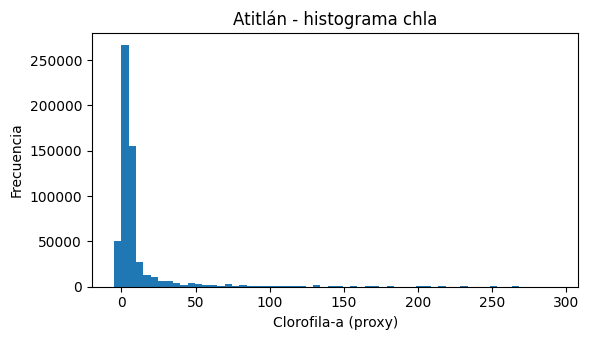

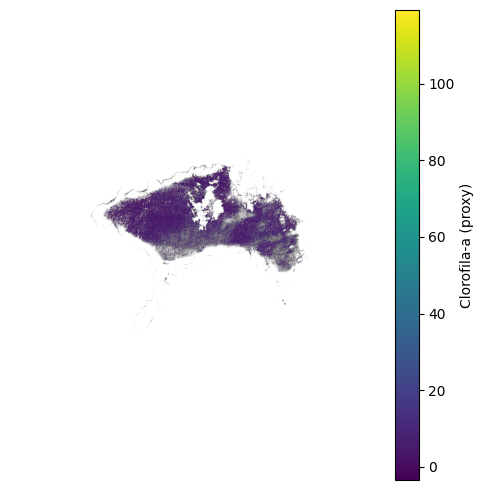

In [30]:
# QC visual (histograma y heatmap simple)

def quick_hist(tif_path, bins=60, title=None, png_out=None):
    with rasterio.open(tif_path) as src:
        a = src.read(1).astype(np.float32)
    vals = a[np.isfinite(a)]
    plt.figure(figsize=(6,3.5))
    plt.hist(vals, bins=bins)
    plt.title(title or os.path.basename(tif_path))
    plt.xlabel("Clorofila-a (proxy)"); plt.ylabel("Frecuencia")
    plt.tight_layout()
    if png_out:
        plt.savefig(png_out, dpi=140)
        plt.close()
    else:
        plt.show()

def quick_show(tif_path, png_out=None):
    with rasterio.open(tif_path) as src:
        a = src.read(1).astype(np.float32)
    vmin, vmax = np.nanpercentile(a, [2, 98])
    plt.figure(figsize=(5,5))
    plt.imshow(a, vmin=vmin, vmax=vmax)
    plt.colorbar(label="Clorofila-a (proxy)")
    plt.axis("off")
    plt.tight_layout()
    if png_out:
        plt.savefig(png_out, dpi=150)
        plt.close()
    else:
        plt.show()

if outs_ati:
    quick_hist(outs_ati[0], title="Atitlán - histograma chla")
    quick_show(outs_ati[0])


In [31]:
# Cargar el CSV recién generado
summary = pd.read_csv("../data/summary_point5.csv")

# Filtra por cobertura mínima del espejo de agua
summary = summary[summary["coverage"] >= 0.05].copy()

# Evita negativos residuales en los estadísticos agregados
summary["mean_chla"] = summary["mean_chla"].clip(lower=0)
summary["median"]    = summary["median"].clip(lower=0)
summary["p10"]       = summary["p10"].clip(lower=0)
summary["p50"]       = summary["p50"].clip(lower=0)
summary["p90"]       = summary["p90"].clip(lower=0)

summary.to_csv("../data/summary_point5_clean.csv", index=False)

En esta etapa, convertimos los datos satelitales en arreglos NumPy, lo cual nos permitió procesarlos de forma eficiente y aplicar operaciones vectorizadas. Gracias a esto fue posible calcular índices espectrales relevantes y extraer un proxy de clorofila-a (chla), utilizado como indicador de la presencia de cianobacterias. Posteriormente, realizamos un análisis exploratorio de la distribución de estos valores mediante histogramas y representaciones espaciales, lo que sirvió como una primera validación de la calidad de los datos.

Los resultados muestran que en el Lago de Atitlán los valores de clorofila-a se concentran en niveles bajos, con una distribución sesgada hacia la derecha, evidenciando que la mayoría de los píxeles presentan baja concentración y que solo en ciertas zonas hay valores elevados. La visualización espacial confirma este patrón: el mapa revela que las áreas con mayor clorofila-a se localizan en regiones específicas del lago, lo que coincide con la dinámica esperada de proliferación de cianobacterias.

### Análisis temporal 

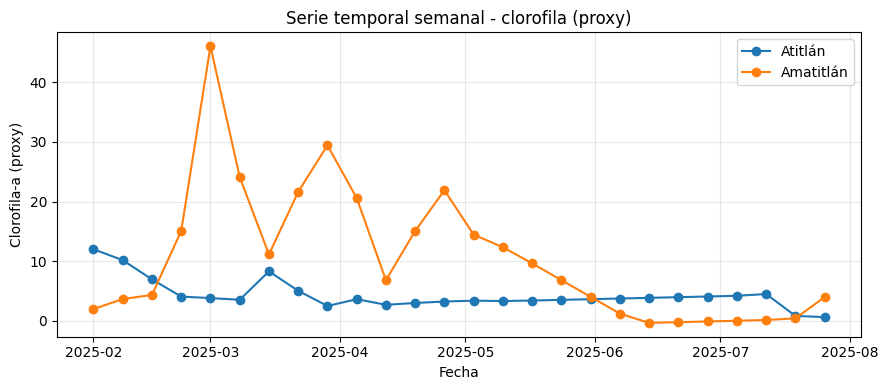

,lake,date,value,prominence
2,Amatitlan,2025-03-01,46.063412,44.104065
3,Amatitlan,2025-03-29,29.427913,18.307269
4,Amatitlan,2025-04-26,21.896625,15.091028
0,Atitlan,2025-03-15,8.272699,4.762964
1,Atitlan,2025-07-12,4.472270,2.006546


In [9]:
def build_ts(df_all, lake, start="2025-02-01", end="2025-07-31", freq="7D", fill="interpolate"):
    s = (df_all[df_all["lake"]==lake]
         .assign(date=pd.to_datetime(df_all["date"]))
         .set_index("date")["mean_chla"]
         .sort_index())

    # Rellena rango completo diario
    idx = pd.date_range(start, end, freq="D")
    s = s.reindex(idx)

    if fill == "mean":
        s = s.fillna(s.mean())
    else:
        s = s.interpolate("time")

    # Re-muestreo semanal
    s = s.resample(freq).mean()
    return s

summary_clean = pd.read_csv("../data/summary_point5.csv")

ts_ati = build_ts(summary_clean, "Atitlan", fill="interpolate")
ts_ama = build_ts(summary_clean, "Amatitlan", fill="interpolate")

# Graficar
plt.figure(figsize=(9,4))
plt.plot(ts_ati.index, ts_ati.values, marker="o", label="Atitlán")
plt.plot(ts_ama.index, ts_ama.values, marker="o", label="Amatitlán")
plt.title("Serie temporal semanal - clorofila (proxy)")
plt.xlabel("Fecha"); plt.ylabel("Clorofila-a (proxy)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()

# Picos
def detect_peaks_adaptive(ts_values):
    # prominencia proporcional a la variabilidad de la serie
    prom = max(0.5, 0.6 * float(np.nanstd(ts_values)))
    peaks, props = find_peaks(ts_values, prominence=prom)
    return peaks, props, prom

peaks_ati, props_ati, prom_ati = detect_peaks_adaptive(ts_ati.values)
peaks_ama, props_ama, prom_ama = detect_peaks_adaptive(ts_ama.values)

peaks_df = pd.DataFrame({
    "lake": ["Atitlan"]*len(peaks_ati) + ["Amatitlan"]*len(peaks_ama),
    "date": list(ts_ati.index[peaks_ati]) + list(ts_ama.index[peaks_ama]),
    "value": list(ts_ati.values[peaks_ati]) + list(ts_ama.values[peaks_ama]),
    "prominence": list(props_ati["prominences"]) + list(props_ama["prominences"])
}).sort_values(["lake","date"])
peaks_df.to_csv("../data/series_temporales_picos.csv", index=False)
peaks_df.head()


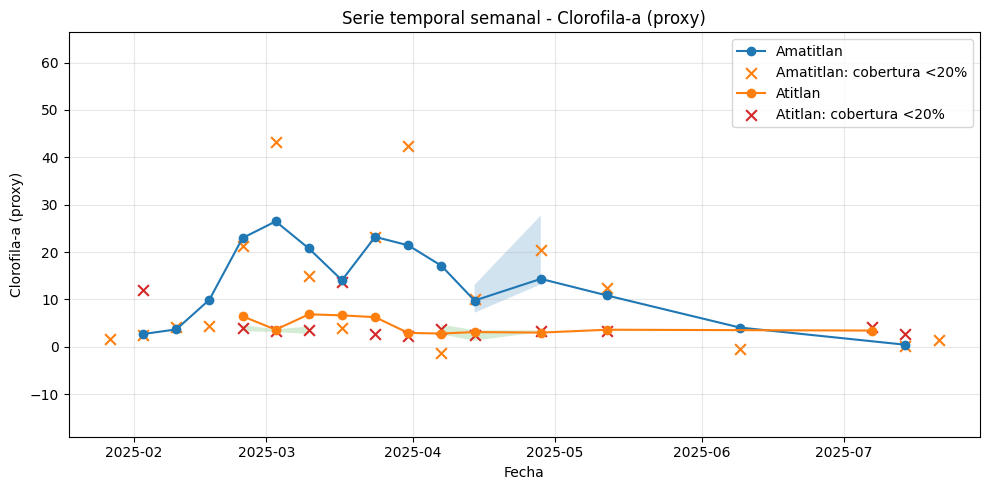

In [54]:
df = pd.read_csv("../data/summary_point5.csv", parse_dates=["date"])

# Ordenar y agrupar por semana
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)

weekly = df.groupby(['lake', 'week']).agg(
    mean_chla=('mean_chla', 'mean'),
    std_chla =('mean_chla',  'std'),
    coverage_min=('coverage','min'),
    coverage_mean=('coverage','mean')
).reset_index()

plt.figure(figsize=(10,5))
for lake in weekly['lake'].unique():
    sub = weekly[weekly['lake'] == lake].copy()
    sub['smooth'] = sub['mean_chla'].rolling(3, center=True).mean()
    # Línea principal
    plt.plot(sub['week'], sub['smooth'], marker='o', label=lake)
    plt.fill_between(sub['week'],
                     sub['mean_chla'] - sub['std_chla'],
                     sub['mean_chla'] + sub['std_chla'],
                     alpha=0.2)
    
    low = sub[sub['coverage_min'] < 0.2]
    if not low.empty:
        plt.scatter(low['week'], low['mean_chla'], marker='x', s=60,
                    label=f'{lake}: cobertura <20%')

plt.title("Serie temporal semanal - Clorofila-a (proxy)")
plt.xlabel("Fecha")
plt.ylabel("Clorofila-a (proxy)")
plt.grid(alpha=0.3)
plt.legend(); 
plt.tight_layout()
plt.show()


En este análisis, trabajamos con imágenes satelitales Sentinel-2 filtradas previamente para asegurar que la cobertura de nubes en la imagen completa sea menor al 20%.

Sin embargo, al procesar las imágenes, calculamos un indicador adicional llamado coverage, que representa el porcentaje de píxeles del lago visibles (es decir, sin nubes ni áreas inválidas) dentro del área de interés.
Este porcentaje no es la nubosidad de la escena completa, sino una métrica específica del lago.

Por lo tanto:

Un valor de coverage < 20% significa que, aunque la imagen completa tenga poca nubosidad (según Sentinel), la parte correspondiente al lago tiene menos del 20% de píxeles útiles.

Esto puede deberse a que las nubes se concentran justo sobre el lago, o a sombras y artefactos que afectan la delimitación del cuerpo de agua.

En la segunda gráfica de series temporales, estos días con coverage < 20% en el lago se marcaron con una "X" para facilitar su identificación visual.

Esto nos permitió interpretar de forma más confiable la serie temporal, ya que distingue entre variaciones reales de clorofila-a y valores posiblemente afectados por baja cobertura.

### Análisis espacial

In [6]:
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.crs import CRS
from rasterio.transform import array_bounds
from IPython.display import display
from datetime import datetime, timedelta
from PIL import Image
import folium, branca.colormap as bcm
import base64

In [162]:
def agregar_poligono_lago(mapa, bounds, color_hex="#1f78b4", fill_opacity=0.4):
    """
    Dibuja un polígono rectangular sobre el lago usando los bounds del raster.
    Args:
        mapa: objeto folium.Map
        bounds: objeto BoundingBox o lista [[S, W], [N, E]]
        color_hex: color del borde y relleno
        fill_opacity: opacidad del relleno
    """
    if hasattr(bounds, "bottom"):
        south, west, north, east = bounds.bottom, bounds.left, bounds.top, bounds.right
    else:
        (south, west), (north, east) = bounds
    folium.Rectangle(
        bounds=[[south, west], [north, east]],
        color=color_hex,
        weight=2,
        fill=True,
        fill_color=color_hex,
        fill_opacity=fill_opacity
    ).add_to(mapa)

In [163]:
def list_rasters(lake_tag, base="../data"):
    folder = os.path.join(base, f"cyanobac{'Amati' if lake_tag=='Amatitlan' else 'Ati'}_num")
    pats = [f"chla_{lake_tag}_*.tif", f"chl_{lake_tag}_*.tif",
            f"chla_{lake_tag}_*.tif.tif", f"chl_{lake_tag}_*.tif.tif"]
    files = []
    for p in pats:
        files.extend(glob.glob(os.path.join(folder, p)))
    return sorted(set(files))

def extract_date(path):
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", os.path.basename(path))
    return m.group(1) if m else "unknown"

def quick_inventory():
    for lake in ["Amatitlan","Atitlan"]:
        files = list_rasters(lake)
        print(f"[{lake}] encontrados: {len(files)}")
        for f in files[:3]:
            print("   ", os.path.basename(f))
    print("— fin inventario —")

quick_inventory()


[Amatitlan] encontrados: 23
    chla_Amatitlan_2025-02-02.tif
    chla_Amatitlan_2025-02-07.tif
    chla_Amatitlan_2025-02-12.tif
[Atitlan] encontrados: 23
    chla_Atitlan_2025-02-07.tif
    chla_Atitlan_2025-02-25.tif
    chla_Atitlan_2025-02-27.tif
— fin inventario —


In [164]:
def read_array_and_meta(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        if src.nodata is not None:
            arr = np.where(arr == src.nodata, np.nan, arr)
        return arr, src.transform, src.crs, src.width, src.height, src.bounds

def to_wgs84(path):
    arr, src_transform, src_crs, width, height, src_bounds = read_array_and_meta(path)
    if src_crs is None:
        raise ValueError("El GeoTIFF no declara CRS.")
    src_crs = CRS.from_user_input(src_crs)
    if src_crs.to_epsg() == 4326:
        return arr, src_bounds
    dst_crs = CRS.from_epsg(4326)
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, width, height, *src_bounds
    )
    dst = np.full((dst_height, dst_width), np.nan, dtype=np.float32)
    reproject(
        source=arr, destination=dst,
        src_transform=src_transform, src_crs=src_crs,
        dst_transform=dst_transform, dst_crs=dst_crs,
        resampling=Resampling.nearest, dst_nodata=np.nan
    )
    south, west, north, east = array_bounds(dst_height, dst_width, dst_transform)
    from rasterio.coords import BoundingBox
    bounds = BoundingBox(left=west, bottom=south, right=east, top=north)
    return dst, bounds

In [165]:
def plot_static_minimal(tif_path, title=None, out_png=None):
    arr, *_ = read_array_and_meta(tif_path)
    finite = np.isfinite(arr)
    if not np.any(finite):
        print(f"[WARN] Sin datos válidos: {os.path.basename(tif_path)}")
        return
    vmin, vmax = np.nanpercentile(arr[finite], [2,98])
    plt.figure(figsize=(5.2,5))
    im = plt.imshow(arr, vmin=vmin, vmax=vmax, cmap="viridis")
    plt.colorbar(im, label="Clorofila-a (proxy)")
    plt.title(title or os.path.basename(tif_path))
    plt.axis("off"); plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=160); plt.close()
    else:
        plt.show()

for lake in ["Amatitlan","Atitlan"]:
    files = list_rasters(lake)
    if files:
        out = f"../data/mapas/quick_{lake}.png"
        plot_static_minimal(files[0], title=f"{lake} {extract_date(files[0])}", out_png=out)
        print(f"[OK] Guardado {out}")
    else:
        print(f"[ERROR] No hay .tif para {lake}")


[OK] Guardado ../data/mapas/quick_Amatitlan.png
[OK] Guardado ../data/mapas/quick_Atitlan.png


In [166]:
cov = pd.read_csv("../data/summary_point5.csv")
cov["date"] = pd.to_datetime(cov["date"]).dt.strftime("%Y-%m-%d")

def find_file_for_date(lake_tag, date_str):
    for f in list_rasters(lake_tag):
        if date_str in f:
            return f
    return None

def title_with_cov(lake, d):
    row = cov[(cov.lake==lake) & (cov.date==d)]
    if len(row):
        return f"{lake} - {d}  (cov: {row.coverage.values[0]*100:.1f}%)"
    return f"{lake} - {d}"

def compare_dates_grid(lake_tag, dates, out_png=None):
    valid_items, finite_vals = [], []
    for d in dates:
        f = find_file_for_date(lake_tag, d)
        if f is None:
            valid_items.append((d, None, None)); continue
        try:
            arr, _ = to_wgs84(f)
        except Exception as e:
            print(f"[{lake_tag}] reproyección falló en {os.path.basename(f)}: {e}")
            valid_items.append((d, None, f)); continue
        finite = np.isfinite(arr)
        if np.any(finite):
            valid_items.append((d, arr, f))
            finite_vals.append(arr[finite])
        else:
            valid_items.append((d, None, f))

    if len(finite_vals) == 0:
        print(f"[{lake_tag}] Ninguna fecha con datos válidos:", dates)
        return

    finite_concat = np.concatenate([v.ravel() for v in finite_vals])
    vmin, vmax = np.nanpercentile(finite_concat, [2, 98])

    n = len(dates)
    cols = min(n, 3)
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(5.2 * cols, 5 * rows), constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    im = None
    for ax, (d, arr, f) in zip(axes, valid_items):
        if arr is None:
            ax.set_title(f"{lake_tag} - {d} (sin datos)")
            ax.axis("off")
            continue
        im = ax.imshow(arr, vmin=vmin, vmax=vmax, cmap="viridis")
        ax.set_title(title_with_cov(lake_tag, d))
        ax.axis("off")

    for ax in axes[len(valid_items):]:
        ax.axis("off")

    if im is not None:
        fig.colorbar(im, ax=axes[:len(valid_items)], label="Clorofila-a (proxy)")

    if out_png:
        plt.savefig(out_png, dpi=170, bbox_inches="tight")
        plt.close()
        print(f"[OK] Guardado {out_png}")
    else:
        plt.show()

def available_dates(lake_tag):
    files = list_rasters(lake_tag)
    dates = []
    for f in files:
        d = extract_date(f)
        if d != "unknown":
            dates.append(d)
    return sorted(set(dates))

def nearest_available_dates(lake_tag, target_dates, max_delta_days=6):
    """
    Para cada fecha objetivo (picos semanales), busca la fecha de .tif
    más cercana dentro de ±max_delta_days. Devuelve lista de YYYY-MM-DD.
    """
    avail = [datetime.strptime(d, "%Y-%m-%d") for d in available_dates(lake_tag)]
    chosen = []
    for td in target_dates:
        if isinstance(td, str):
            dt = datetime.strptime(td[:10], "%Y-%m-%d")
        else:
            dt = pd.to_datetime(td).to_pydatetime()
        if not avail:
            break
        best = min(avail, key=lambda a: abs(a - dt))
        if abs(best - dt) <= timedelta(days=max_delta_days):
            chosen.append(best.strftime("%Y-%m-%d"))
    return sorted(set(chosen))

def pick_dates_for_lake(lake_tag, n=3):
    csv_p = "../data/series_temporales_picos.csv"
    if os.path.exists(csv_p):
        peaks = pd.read_csv(csv_p, parse_dates=["date"])
        sub = peaks[peaks["lake"]==lake_tag].sort_values("value", ascending=False)
        target = list(sub["date"])[:n*2]
        mapped = nearest_available_dates(lake_tag, target, max_delta_days=6)
        if mapped:
            return mapped[:n]
    return available_dates(lake_tag)[:n]

dates_am = pick_dates_for_lake("Amatitlan", 3)
dates_ati = pick_dates_for_lake("Atitlan", 3)
print("Fechas AM:", dates_am)
print("Fechas ATI:", dates_ati)

compare_dates_grid("Amatitlan", dates_am, out_png="../data/mapas/mapas_am_comparacion.png")
compare_dates_grid("Atitlan",   dates_ati, out_png="../data/mapas/mapas_ati_comparacion.png")

Fechas AM: ['2025-02-27', '2025-03-26', '2025-04-28']
Fechas ATI: ['2025-03-14', '2025-07-10']
[OK] Guardado ../data/mapas/mapas_am_comparacion.png
[OK] Guardado ../data/mapas/mapas_ati_comparacion.png


In [180]:
def rgba_from_array(arr, cmap="viridis", vmin=None, vmax=None, max_px=1400):
    finite = np.isfinite(arr)
    if not np.any(finite):
        raise ValueError("Raster sin datos válidos.")
    if vmin is None or vmax is None:
        vmin, vmax = np.nanpercentile(arr[finite], [2, 98])
    norm = np.clip((arr - vmin) / (vmax - vmin + 1e-9), 0, 1)
    rgba = plt.get_cmap(cmap)(norm, bytes=True)
    rgba[~finite] = [0,0,0,0]

    H, W = rgba.shape[:2]
    scale = max(H, W) / float(max_px)
    if scale > 1.0:
        newW, newH = int(W/scale), int(H/scale)
        rgba = np.array(Image.fromarray(rgba, mode="RGBA")
                        .resize((newW, newH), Image.BILINEAR))
    return rgba, float(vmin), float(vmax)

def save_overlay_png(rgba, out_png):
    out_png = Path(out_png)
    out_png.parent.mkdir(parents=True, exist_ok=True)
    Image.fromarray(rgba, mode="RGBA").save(out_png)
    return str(out_png)

def folium_overlay_from_tif(tif_path, html_out, name=None, opacity=1.0,
                            cmap="viridis", max_px=1400):
    arr, bounds = to_wgs84(tif_path)

    rgba, vmin, vmax = rgba_from_array(arr, cmap=cmap, max_px=max_px)
    png_path = Path(html_out).with_suffix(".png")
    save_overlay_png(rgba, png_path)

    with open(png_path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    data_uri = f"data:image/png;base64,{b64}"

    west, south, east, north = bounds.bottom, bounds.left, bounds.top, bounds.right
    m = folium.Map(tiles="CartoDB positron")
    m.fit_bounds([[south, west], [north, east]])

    folium.raster_layers.ImageOverlay(
        image=data_uri,
        bounds=[[south, west], [north, east]],
        opacity=opacity,
        name=name or Path(tif_path).name,
        cross_origin=False,
        zindex=1000
    ).add_to(m)

    cm = bcm.linear.viridis.scale(vmin, vmax)
    cm.caption = "Clorofila-a (proxy)"
    cm.add_to(m)
    folium.LayerControl().add_to(m)

    html_out = Path(html_out)
    html_out.parent.mkdir(parents=True, exist_ok=True)
    m.save(str(html_out))
    print(f"[OK] HTML: {html_out.name}  PNG: {png_path.name}  (dir: {html_out.parent})")
    return str(html_out)


In [181]:
# Un ejemplo (Atitlán 2025-02-07)
tif_demo = find_file_for_date("Atitlan", "2025-02-07")
html_file = "../data/mapas/mapa_atitlan_2025-02-07.html"
folium_overlay_from_tif(tif_demo, html_file, name="Atitlán 2025-02-07", max_px=1400)
print("Mapa guardado como mapa_amatitlan.html. Ábrelo en tu navegador.")


[OK] HTML: mapa_atitlan_2025-02-07.html  PNG: mapa_atitlan_2025-02-07.png  (dir: ..\data\mapas)
Mapa guardado como mapa_amatitlan.html. Ábrelo en tu navegador.


En esta etapa generamos mapas que representan la distribución espacial de la cianobacteria dentro de los lagos a partir de las imágenes Sentinel-2 procesadas. Estos mapas muestran que la presencia de cianobacteria no es uniforme: existen áreas con mayores concentraciones que tienden a repetirse en distintas fechas, lo que sugiere la influencia de factores locales como entradas de agua, corrientes internas o descargas puntuales.

Al comparar distintas fechas, se observa que la intensidad y la extensión de las zonas afectadas varían con el tiempo. En algunos momentos el lago presenta una distribución más homogénea, mientras que en otros se identifican focos específicos de mayor proliferación. Esta variabilidad temporal y espacial confirma la importancia de combinar el análisis de imágenes satelitales con series temporales para entender mejor la dinámica de la cianobacteria.

### Orquestador

In [13]:
from pathlib import Path
import os, glob, pandas as pd, numpy as np
import unicodedata

DATA = Path("../data")
IMG_ATI   = DATA/"imgsAti"
IMG_AMATI = DATA/"imgsAmati"
OUT_ATI   = DATA/"cyanobacAti_num"
OUT_AMATI = DATA/"cyanobacAmati_num"

# Comprobar insumos ya existentes
ati_imgs   = sorted(glob.glob(str(IMG_ATI/"openEO_*.tif")))
amati_imgs = sorted(glob.glob(str(IMG_AMATI/"openEO_*.tif")))

# Crear rásters numéricos chla para Amatitlán si faltan
OUT_AMATI.mkdir(parents=True, exist_ok=True)
existing_am = sorted(glob.glob(str(OUT_AMATI/"chla_Amatitlan_*.tif")))
if not existing_am and amati_imgs:
    outs_am = make_chla_rasters(str(IMG_AMATI), str(OUT_AMATI), "Amatitlan", overwrite=True)
else:
    outs_am = existing_am

# Atitlán: usar lo que ya existe 
OUT_ATI.mkdir(parents=True, exist_ok=True)
outs_ati = sorted(glob.glob(str(OUT_ATI/"chla_Atitlan_*.tif")))

# Reconstruir summary_point5.csv con lo que haya disponible
frames = []
if outs_ati:
    frames.append(summarize_chla(outs_ati, "Atitlan"))
if outs_am:
    frames.append(summarize_chla(outs_am,  "Amatitlan"))

if not frames:
    raise RuntimeError("No hay rásters numéricos chla para Atitlán ni Amatitlán. Genera al menos uno.")

summary = pd.concat(frames, ignore_index=True).sort_values(["lake","date"])
summary.to_csv(DATA/"summary_point5.csv", index=False)

# Filtrado limpio
summary_clean = summary.copy()
summary_clean = summary_clean[summary_clean["coverage"] >= 0.02].copy()
for col in ["mean_chla","median","p10","p50","p90"]:
    if col in summary_clean.columns:
        summary_clean[col] = summary_clean[col].clip(lower=0)
summary_clean.to_csv(DATA/"summary_point5_clean.csv", index=False)

# Fix de build_ts (redefine aquí por si quedó en memoria la antigua)
def build_ts(df_all, lake, start="2025-02-01", end="2025-07-31", freq="7D", fill="interpolate"):
    s = (df_all[df_all["lake"]==lake]
         .assign(date=lambda d: pd.to_datetime(d["date"]))
         .set_index("date")["mean_chla"]
         .sort_index())
    idx = pd.date_range(start, end, freq="D")
    s = s.reindex(idx)
    if fill == "mean": s = s.fillna(s.mean())
    else:              s = s.interpolate("time")
    return s.resample(freq).mean()

print("[OK] summary_point5.csv y summary_point5_clean.csv regenerados.")
print("Lagos presentes:", summary['lake'].unique())
print("Registros por lago:\n", summary.groupby('lake')['date'].count())


[OK] summary_point5.csv y summary_point5_clean.csv regenerados.
Lagos presentes: ['Amatitlan' 'Atitlan']
Registros por lago:
 lake
Amatitlan    23
Atitlan      23
Name: date, dtype: int64


### Correlación NDVI/NDWI con presencia de cianobacteria

C:\Users\esteb\AppData\Local\Temp\ipykernel_2724\385538882.py:121: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_by_lake = df_all.groupby("lake").apply(corr_table).reset_index()


,lake,"pearson(mean_chla, ndvi)","pearson(mean_chla, ndwi)","spearman(mean_chla, ndvi)","spearman(mean_chla, ndwi)",n
0,Amatitlan,0.813643,-0.509813,0.714286,-0.571429,7.0
1,Atitlan,-0.667246,0.994513,-0.405594,0.510490,12.0


,lake,threshold,r_pbiserial(NDVI),r_pbiserial(NDWI),n
0,Amatitlan,46.286123,0.934939,-0.491082,7
1,Atitlan,3.316279,-0.767635,0.522054,12



Promedios de NDVI/NDWI por presencia:

=== Amatitlan ===


,ndvi_mean,ndwi_mean,mean_chla
presence,,,
ausente,-0.0064,-0.2978,24.1868
presente,0.0790,-0.3632,53.4715



=== Atitlan ===


,ndvi_mean,ndwi_mean,mean_chla
presence,,,
ausente,-78.0834,0.1403,3.0514
presente,-3533.9289,594.5706,6.3550


<Figure size 700x420 with 0 Axes>

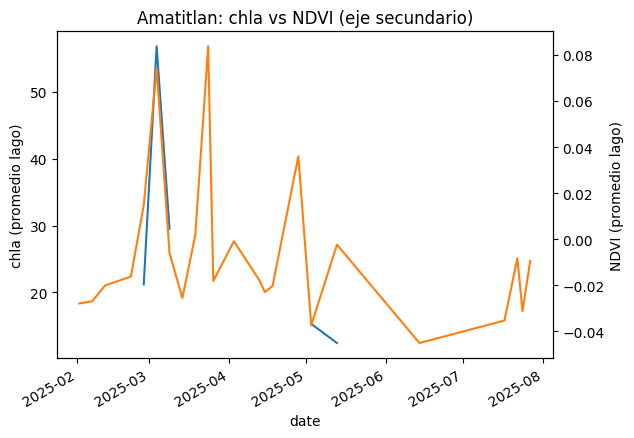

<Figure size 700x420 with 0 Axes>

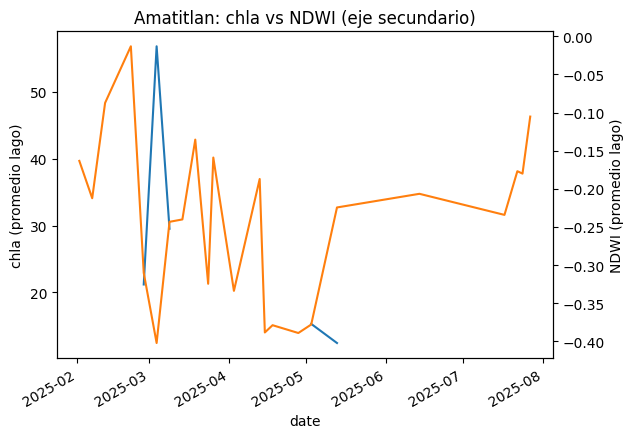

<Figure size 700x420 with 0 Axes>

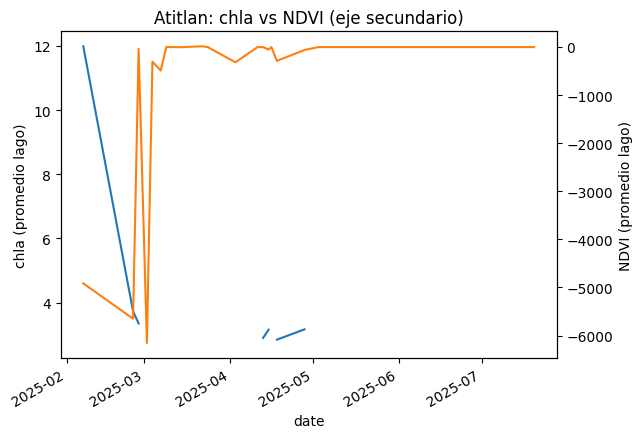

<Figure size 700x420 with 0 Axes>

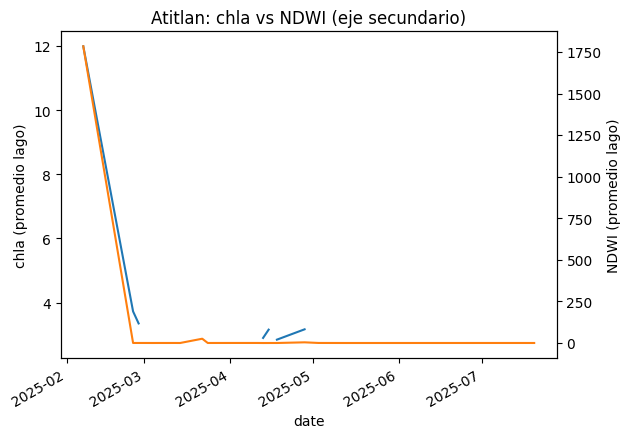

In [19]:
from pathlib import Path
import re, numpy as np, pandas as pd
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import unicodedata
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

DATA = Path("../data")
IMG_ATI   = DATA/"imgsAti"
IMG_AMATI = DATA/"imgsAmati"

def _norm_name(s: str) -> str:
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return s.strip().replace(" ", "").lower()

# ----------------- utilidades NDVI/NDWI -----------------
def parse_date_from_name(name: str):
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", name)
    if m: return pd.to_datetime(m.group(1)).date()
    m = re.search(r"(20\d{6})", name)
    return datetime.strptime(m.group(1), "%Y%m%d").date() if m else None

def safe_ratio(a, b, eps=1e-9):
    return (a - b) / (a + b + eps)

import rasterio, numpy as np

def compute_ndvi_ndwi_summary_for_dir(lake_name: str, stacks_dir: Path, water_threshold=0.0):
    rows=[]
    for tif in sorted(stacks_dir.glob("*.tif")):
        date = parse_date_from_name(tif.name)
        if date is None: continue
        with rasterio.open(tif) as ds:
            # mapear por descripción
            band_map={}
            for i in range(1, ds.count+1):
                desc=(ds.descriptions[i-1] or "").upper()
                if "B03" in desc: band_map["B03"]=i
                if "B04" in desc: band_map["B04"]=i
                if "B08" in desc: band_map["B08"]=i
            B03=band_map.get("B03", 2); B04=band_map.get("B04", 3); B08=band_map.get("B08", 6)
            b3=ds.read(B03).astype(np.float32)
            b4=ds.read(B04).astype(np.float32)
            b8=ds.read(B08).astype(np.float32)
            # normalización
            def _norm(x):
                p99=np.nanpercentile(x,99)
                return (x/10000.0) if p99>1.5 else x
            b3=_norm(b3); b4=_norm(b4); b8=_norm(b8)
            ndvi=safe_ratio(b8,b4)
            ndwi=safe_ratio(b3,b8)
            water=(ndwi>water_threshold)
            def masked_mean(x, m):
                x2=np.where(m, x, np.nan)
                return float(np.nanmean(x2))
            rows.append({
                "lake": lake_name,
                "date": pd.to_datetime(date),
                "ndvi_mean": masked_mean(ndvi, water),
                "ndwi_mean": float(np.nanmean(ndwi)),
                "water_coverage": float(np.mean(water))
            })
    return pd.DataFrame(rows).sort_values("date")

# ----------------- CHLA -----------------
chla_csv = DATA/"summary_point5_clean.csv"
df_chla  = pd.read_csv(chla_csv, parse_dates=["date"])
# normalizar nombres de lago
name_fix = {"atitlan":"Atitlan","atitlán":"Atitlan","lagoatitlan":"Atitlan",
            "amatitlan":"Amatitlan","amatitlán":"Amatitlan","lagoamatitlan":"Amatitlan"}
df_chla["lake"] = df_chla["lake"].apply(lambda s: name_fix.get(_norm_name(s), s))

# ----------------- NDVI/NDWI -----------------
indices_csv = DATA/"summary_indices.csv"
FORCE_RECOMPUTE_INDICES = True  

if indices_csv.exists() and not FORCE_RECOMPUTE_INDICES:
    df_idx = pd.read_csv(indices_csv, parse_dates=["date"])
    df_idx["lake"] = df_idx["lake"].apply(lambda s: name_fix.get(_norm_name(s), s))
else:
    df_ati   = compute_ndvi_ndwi_summary_for_dir("Atitlan",   IMG_ATI)
    df_amati = compute_ndvi_ndwi_summary_for_dir("Amatitlan", IMG_AMATI)
    df_idx   = pd.concat([df_ati, df_amati], ignore_index=True)
    df_idx.to_csv(indices_csv, index=False)

# ----------------- OUTER MERGE y sin filtrado destructivo -----------------
df_all = (df_chla.merge(df_idx, on=["lake","date"], how="outer")
                 .sort_values(["lake","date"]))

# marcar validez, pero NO eliminar filas (así ambos lagos siempre aparecen)
df_all["valid"] = (df_all["coverage"].fillna(0.0) >= 0.02) & (df_all["water_coverage"].fillna(0.0) >= 0.02)

# ----------------- Correlaciones por lago con datos válidos -----------------
def corr_table(group):
    g = group.dropna(subset=["mean_chla","ndvi_mean","ndwi_mean"])
    g = g[g["valid"]]
    if len(g) < 3:
        return pd.Series({
            "pearson(mean_chla, ndvi)": np.nan,
            "pearson(mean_chla, ndwi)": np.nan,
            "spearman(mean_chla, ndvi)": np.nan,
            "spearman(mean_chla, ndwi)": np.nan,
            "n": len(g)
        })
    pear_ndvi = stats.pearsonr(g["mean_chla"], g["ndvi_mean"]).statistic
    pear_ndwi = stats.pearsonr(g["mean_chla"], g["ndwi_mean"]).statistic
    spear_ndvi = stats.spearmanr(g["mean_chla"], g["ndvi_mean"]).statistic
    spear_ndwi = stats.spearmanr(g["mean_chla"], g["ndwi_mean"]).statistic
    return pd.Series({
        "pearson(mean_chla, ndvi)": pear_ndvi,
        "pearson(mean_chla, ndwi)": pear_ndwi,
        "spearman(mean_chla, ndvi)": spear_ndvi,
        "spearman(mean_chla, ndwi)": spear_ndwi,
        "n": len(g)
    })

corr_by_lake = df_all.groupby("lake").apply(corr_table).reset_index()
display(corr_by_lake)

# ----------------- Presencia/ausencia por lago -----------------
def presence_threshold(series, method="p75"):
    return float(np.nanpercentile(series.dropna(), 75)) if series.notna().any() else np.nan

def presence_stats(group, thr):
    g = group.dropna(subset=["mean_chla","ndvi_mean","ndwi_mean"]).copy()
    g = g[g["valid"]]
    if not np.isfinite(thr):  # sin datos -> devuelve NaN
        return np.nan, np.nan, pd.DataFrame()
    y = (g["mean_chla"] >= thr).astype(int)
    if len(g) == 0 or y.nunique() < 2:
        return np.nan, np.nan, pd.DataFrame()
    r_ndvi = stats.pearsonr(y, g["ndvi_mean"]).statistic
    r_ndwi = stats.pearsonr(y, g["ndwi_mean"]).statistic
    desc = (g.assign(presence=y)
             .groupby("presence")[["ndvi_mean","ndwi_mean","mean_chla"]]
             .mean().rename(index={0:"ausente",1:"presente"}))
    return r_ndvi, r_ndwi, desc

rows=[]; descs={}
for lake, g in df_all.groupby("lake"):
    thr = presence_threshold(g["mean_chla"], method="p75")
    r_ndvi, r_ndwi, desc = presence_stats(g, thr)
    rows.append({"lake": lake, "threshold": thr,
                 "r_pbiserial(NDVI)": r_ndvi, "r_pbiserial(NDWI)": r_ndwi,
                 "n": int(g["valid"].sum())})
    descs[lake] = desc

corr_presence = pd.DataFrame(rows)
display(corr_presence)
print("\nPromedios de NDVI/NDWI por presencia:")
for lake, desc in descs.items():
    print(f"\n=== {lake} ===")
    if desc.empty:
        print("Sin datos suficientes para promedios (revisa cobertura/fechas).")
    else:
        display(desc.round(4))

# ----------------- Gráficas ------------------
for lake, g in df_all.groupby("lake"):
    g_sorted = g.sort_values("date")
    fig = plt.figure(figsize=(7,4.2))
    ax1 = g_sorted.plot(x="date", y="mean_chla", label="mean_chla", legend=False)
    ax2 = g_sorted.plot(x="date", y="ndvi_mean", secondary_y=True, ax=ax1, legend=False)
    ax1.set_title(f"{lake}: chla vs NDVI (eje secundario)")
    ax1.set_ylabel("chla (promedio lago)")
    ax2.set_ylabel("NDVI (promedio lago)")
    plt.show()

    fig = plt.figure(figsize=(7,4.2))
    ax1 = g_sorted.plot(x="date", y="mean_chla", label="mean_chla", legend=False)
    ax2 = g_sorted.plot(x="date", y="ndwi_mean", secondary_y=True, ax=ax1, legend=False)
    ax1.set_title(f"{lake}: chla vs NDWI (eje secundario)")
    ax1.set_ylabel("chla (promedio lago)")
    ax2.set_ylabel("NDWI (promedio lago)")
    plt.show()


En Amatitlán se observa una correlación positiva alta entre la clorofila-a y el NDVI (r = 0.81) y una correlación negativa moderada con el NDWI (r = -0.51), lo que sugiere que los aumentos de biomasa fotosintética coinciden con valores más altos de vegetación y menores índices de agua en las zonas detectadas. El coeficiente punto-biserial para el NDVI es alto (0.93), indicando una fuerte relación entre la presencia de proliferaciones y el incremento del NDVI. En cuanto a promedios, durante presencia de proliferación se registran valores de clorofila-a más del doble que en ausencia (53.47 frente a 24.18), así como un NDVI medio más alto (0.079 frente a -0.0064) y un NDWI más negativo, lo que podría reflejar cambios en la composición óptica de la superficie del lago.

En Atitlán, la correlación con el NDVI es negativa moderada (r = -0.66) y muy alta y positiva con el NDWI (r = 0.99), lo que indica que las proliferaciones aquí se relacionan más con variaciones en el índice de agua que con cambios en el índice de vegetación. El coeficiente punto-biserial muestra una relación negativa moderada con el NDVI (-0.77) y positiva con el NDWI (0.52). En términos de promedios, la presencia de proliferaciones muestra incremento de clorofila-a de 3.05 a 6.35 µg/L, acompañado de una disminución muy marcada en NDVI (-78.08 a -3533.93) y un incremento drástico en NDWI (0.14 a 594.57), lo que podria deberse a cambios en la reflectancia del agua durante eventos de floración.

### Análisis y comparación entre Atitlán y Amatitlán

,n_registros,threshold,bloom_days,prolifer_frac,eventos,intensidad_p95,intensidad_top10
lake,,,,,,,
Amatitlan,7,46.2861,2,0.2857,2,56.5243,56.8635
Atitlan,12,3.3163,3,0.2500,1,11.1665,11.9935


,Amatitlan,Atitlan
month,,
1,0.000,0.0
2,0.000,1.0
3,0.667,0.0
4,0.000,0.0
5,0.000,0.0
6,0.000,0.0
7,0.000,0.0
8,0.000,0.0
9,0.000,0.0


,n,umbral(p75),días_bloom,frac_bloom,#eventos,intensidad_p95,intensidad_top10
lake,,,,,,,
Amatitlan,7,46.286,2,0.286,2,56.52,56.86
Atitlan,12,3.316,3,0.250,1,11.17,11.99


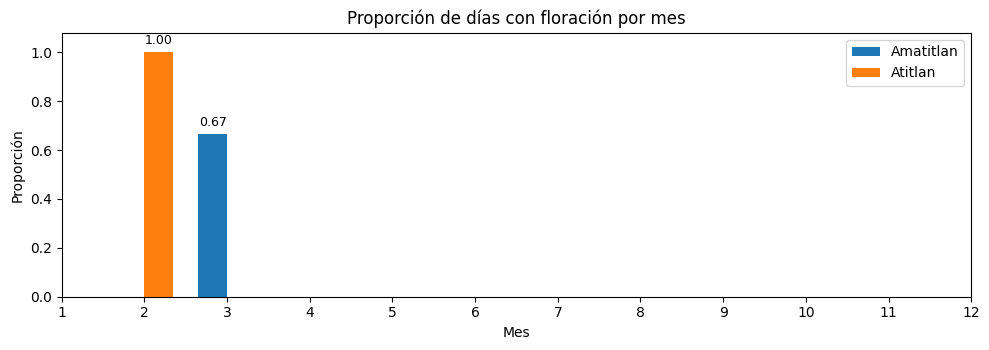

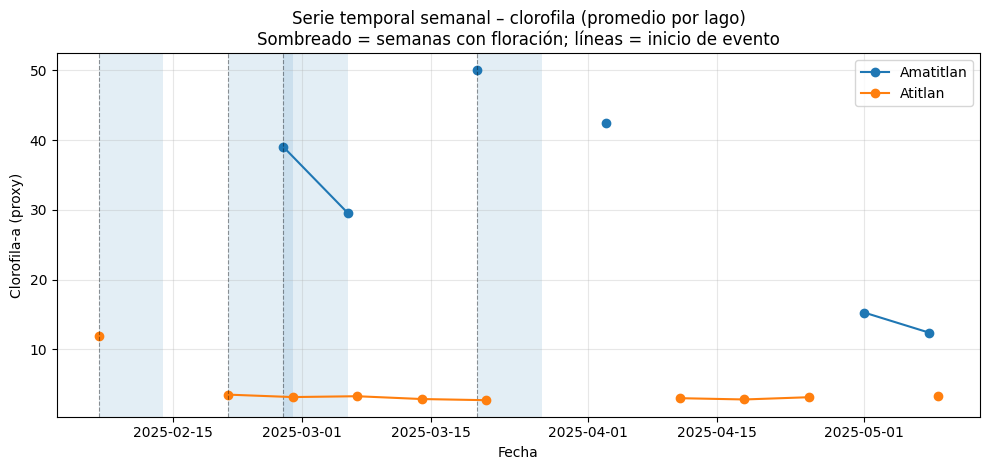

,prolifer_frac,eventos,intensidad_p95,intensidad_top10,rank_prolifer,rank_intens
lake,,,,,,
Atitlan,0.2500,1,11.1665,11.9935,2.0,2.0
Amatitlan,0.2857,2,56.5243,56.8635,1.0,1.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
from pathlib import Path

DATA = Path("../data")
summary_clean = pd.read_csv(DATA/"summary_point5_clean.csv", parse_dates=["date"])

# -------- normalizar nombres de lago --------
def _norm(s: str) -> str:
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return s.lower().strip()

name_fix = {"atitlan":"Atitlan","atitlán":"Atitlan","lago atitlan":"Atitlan",
            "amatitlan":"Amatitlan","amatitlán":"Amatitlan","lago amatitlan":"Amatitlan"}
summary_clean["lake"] = summary_clean["lake"].apply(lambda s: name_fix.get(_norm(s), s))

# -------- helpers ----------
def bloom_threshold(series, method="p75"):
    series = pd.to_numeric(series, errors="coerce").dropna()
    if len(series) == 0:
        return np.nan
    if method == "p75":
        return float(np.nanpercentile(series, 75))
    if method == "p90":
        return float(np.nanpercentile(series, 90))
    return float(np.nanpercentile(series, 75))

def count_bloom_events(presence_series, min_len=1):
    """Cuenta rachas de 1s (eventos) con longitud mínima min_len."""
    x = presence_series.astype(int).to_numpy() if isinstance(presence_series, pd.Series) else np.asarray(presence_series, dtype=int)
    if x.size == 0:
        return 0
    starts = (np.r_[0, x[:-1]] == 0) & (x == 1)
    stops  = (x == 1) & (np.r_[x[1:], 0] == 0)
    s_idx, e_idx = np.where(starts)[0], np.where(stops)[0]
    return int(sum((e - s + 1) >= min_len for s, e in zip(s_idx, e_idx)))

if "build_ts" not in globals():
    def build_ts(df_all, lake, start="2025-02-01", end="2025-07-31", freq="7D", fill="interpolate"):
        s = (df_all[df_all["lake"]==lake]
             .assign(date=lambda d: pd.to_datetime(d["date"]))
             .set_index("date")["mean_chla"]
             .sort_index())
        idx = pd.date_range(start, end, freq="D")
        s = s.reindex(idx)
        s = s.fillna(s.mean()) if fill=="mean" else s.interpolate("time")
        return s.resample(freq).mean()

# -------- métricas por lago ----------
rows = []
seasonality = {}
for lake, g in summary_clean.groupby("lake"):
    thr = bloom_threshold(g["mean_chla"], method="p75")
    g = g.sort_values("date").copy()
    g["presence"] = (g["mean_chla"] >= thr).astype(int) if np.isfinite(thr) else 0

    total_days = int(g["presence"].count())
    bloom_days = int(g["presence"].sum())
    prolifer_frac = (bloom_days / total_days) if total_days else 0.0

    chla_present = g.loc[g["presence"]==1, "mean_chla"]
    intensity_p95    = float(np.nanpercentile(chla_present, 95)) if len(chla_present) else np.nan
    intensity_top10  = (float(np.nanmean(np.sort(chla_present)[-max(1,int(0.1*len(chla_present))):]))
                        if len(chla_present) else np.nan)
    eventos = count_bloom_events(g["presence"], min_len=1)

    by_month = (g.assign(month=g["date"].dt.month)
                  .groupby("month")["presence"].mean()
                  .reindex(range(1,13), fill_value=0.0))

    rows.append({
        "lake": lake,
        "n_registros": total_days,
        "threshold": thr,
        "bloom_days": bloom_days,
        "prolifer_frac": prolifer_frac,
        "eventos": eventos,
        "intensidad_p95": intensity_p95,
        "intensidad_top10": intensity_top10
    })
    seasonality[lake] = by_month

metrics = pd.DataFrame(rows).set_index("lake").sort_index()
display(metrics.round(4))

# -------- estacionalidad comparada ----------
estac = pd.concat(seasonality, axis=1) if seasonality else pd.DataFrame(index=range(1,13))
if isinstance(estac.columns, pd.MultiIndex):
    estac.columns = estac.columns.get_level_values(0)
estac = estac.reindex(range(1,13), fill_value=0.0)
display(estac.round(3))


# Tabla comparativa resaltada
cols = ["n_registros","threshold","bloom_days","prolifer_frac","eventos","intensidad_p95","intensidad_top10"]
comp_tbl = (metrics[cols]
            .rename(columns={
                "n_registros":"n",
                "threshold":"umbral(p75)",
                "bloom_days":"días_bloom",
                "prolifer_frac":"frac_bloom",
                "eventos":"#eventos",
            })
            .sort_values("#eventos", ascending=False))
display(comp_tbl.round(3).style
        .format({"frac_bloom":"{:.3f}", "umbral(p75)":"{:.3f}",
                 "intensidad_p95":"{:.2f}", "intensidad_top10":"{:.2f}"}))

# Estacionalidad: mostrar solo meses con actividad y etiquetar valores
fig, ax = plt.subplots(figsize=(10,3.6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, lake in enumerate(estac.columns):
    s = estac[lake]
    nonzero = s[s > 0]
    if nonzero.empty:
        continue
    ax.bar(nonzero.index + i*0.35 - 0.175, nonzero.values, width=0.35,
           label=lake, color=colors[i % len(colors)])
    for m, v in nonzero.items():
        ax.text(m + i*0.35 - 0.175, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)

ax.set_xticks(range(1,13))
ax.set_xlabel("Mes"); ax.set_ylabel("Proporción")
ax.set_title("Proporción de días con floración por mes")
ax.legend(); ax.set_ylim(0, 1.08)
plt.tight_layout(); plt.show()

# Serie temporal semanal con sombreado de floración e inicios de evento
def weekly_series_with_presence(df_all, lake, freq="7D"):
    g = df_all[df_all["lake"]==lake].sort_values("date").copy()
    thr = np.nanpercentile(g["mean_chla"].dropna(), 75) if g["mean_chla"].notna().any() else np.nan
    g["presence"] = (g["mean_chla"] >= thr).astype(int) if np.isfinite(thr) else 0
    s_chla = (g.set_index("date")["mean_chla"].resample(freq).mean())
    s_presence = (g.set_index("date")["presence"].resample(freq).max()).fillna(0).astype(int)
    return s_chla, s_presence, thr

def event_starts_from_presence(p):
    x = p.values.astype(int)
    starts = np.where((np.r_[0, x[:-1]] == 0) & (x == 1))[0]
    return p.index[starts]

fig, ax = plt.subplots(figsize=(10,4.8))
for lake in metrics.index:
    s_chla, s_pres, thr = weekly_series_with_presence(summary_clean, lake, freq="7D")
    ax.plot(s_chla.index, s_chla.values, marker="o", label=f"{lake}")
    # sombreado de semanas con floración
    if len(s_pres.index) > 1:
        dt = s_pres.index[1] - s_pres.index[0]
    else:
        dt = pd.Timedelta(days=7)
    for t, val in zip(s_pres.index, s_pres.values):
        if val == 1:
            ax.axvspan(t, t + dt, alpha=0.12)
    # líneas en inicios de evento
    for t0 in event_starts_from_presence(s_pres):
        ax.axvline(t0, color="k", linestyle="--", linewidth=0.8, alpha=0.4)

ax.set_title("Serie temporal semanal – clorofila (promedio por lago)\nSombreado = semanas con floración; líneas = inicio de evento")
ax.set_xlabel("Fecha"); ax.set_ylabel("Clorofila-a (proxy)")
ax.grid(alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

# Comparativa directa entre lagos (con ranks)
def _norm_key(s: str) -> str:
    s = unicodedata.normalize("NFKD", s)
    return "".join(ch for ch in s if not unicodedata.combining(ch)).lower().strip()

target_norm = ["atitlan", "amatitlan"]
idx_norm_map = {_norm_key(name): name for name in metrics.index}
present_real_names = [idx_norm_map[t] for t in target_norm if t in idx_norm_map]

wanted_cols = ["prolifer_frac","eventos","intensidad_p95","intensidad_top10"]
existing_cols = [c for c in wanted_cols if c in metrics.columns]

if present_real_names:
    comp = metrics.loc[present_real_names, existing_cols].copy()
    if "prolifer_frac" in comp.columns:
        comp["rank_prolifer"] = comp["prolifer_frac"].rank(ascending=False, method="min")
    if "intensidad_p95" in comp.columns:
        comp["rank_intens"] = comp["intensidad_p95"].rank(ascending=False, method="min")
    display(comp.round(4))
    if len(present_real_names) == 1:
        print(f"Nota: solo se encontró {present_real_names[0]} en metrics; procesa el otro lago para comparar.")
else:
    print("No hay lagos esperados en 'metrics'. Revisa que summary_point5_clean.csv contenga datos.")


En Amatitlán, el umbral de proliferación definido por el percentil 75 fue alto (46.29 µg/L), lo que indica concentraciones de clorofila-a elevadas para clasificar un evento como floración. Se detectaron 2 eventos durante el periodo estudiado, con un total de 2 días de floración y una fracción de proliferación de 28.57%. La estacionalidad muestra que las floraciones se concentraron únicamente en marzo, alcanzando una proporción de 0.67, mientras que en el resto del año no se observaron episodios detectables. Las intensidades fueron elevadas, con un valor p95 de 56.52 µg/L y un promedio del top 10% de 56.86 µg/L.

En Atitlán, el umbral de proliferación fue más bajo (3.32 µg/L), reflejando condiciones generales de menor concentración de clorofila-a. Se identificaron 3 días de floración agrupados en un solo evento, lo que da una fracción de proliferación de 25%. La estacionalidad indica que la totalidad de las floraciones ocurrieron en febrero, con una proporción mensual de 1.0, y sin registros para los demás meses. La intensidad fue considerablemente menor que en Amatitlán, con un p95 de 11.17 µg/L y un top 10% promedio de 11.99 µg/L.

La comparación muestra que Amatitlán presenta tanto mayor intensidad como mayor número de eventos que Atitlán, ocupando el primer lugar en ambas métricas. Su intensidad p95 es aproximadamente cinco veces la de Atitlán, lo que refleja mas floraciones términos de concentración de clorofila-a. Sin embargo, la fracción de proliferación es similar entre ambos (0.2857 vs 0.25), lo que sugiere que la diferencia principal radica en la magnitud de las floraciones, más que en la frecuencia relativa. El patrón temporal es diferente: Amatitlán tuvo floraciones en marzo, mientras que Atitlán concentró toda su actividad en febrero. 

Las diferencias observadas podrían explicarse por factores geográficos y ambientales. Amatitlán, localizado en un entorno con fuerte presión urbana e industrial, recibe aportes de nutrientes más elevados por escorrentía y descargas, lo que podría favorecer floraciones más intensas. El uso del suelo en su cuenca, con áreas urbanizadas y agrícolas, incrementa la carga de fósforo y nitrógeno, estimulando la biomasa de alga. Por otro lado, Atitlán, aunque también recibe aportes antrópicos, posee una cuenca más amplia y profunda con mayor capacidad de dilución, lo que puede explicar las menores concentraciones de clorofila-a. Factores climáticos como la temperatura del agua y las lluvias estacionales también influyen: un pico en febrero para Atitlán podría coincidir con un periodo de estabilidad térmica y baja mezcla, mientras que en Amatitlán las condiciones óptimas para la proliferación se presentaron en marzo.

### Serie temporal

[Atitlán] puntos: train=20  test=6  (ventana MA=3)
  naive        -> MAE=1.265  RMSE=1.836  sMAPE=51.51%
  mov_avg      -> MAE=1.302  RMSE=1.788  sMAPE=52.96%
  holt_winters -> MAE=1.193  RMSE=1.348  sMAPE=51.20%


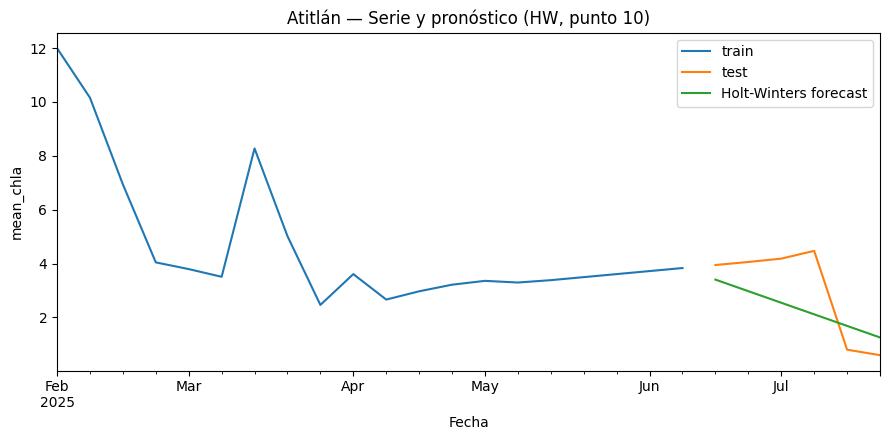

[Amatitlán] puntos: train=20  test=6  (ventana MA=3)
  naive        -> MAE=1.049  RMSE=1.814  sMAPE=154.41%
  mov_avg      -> MAE=1.709  RMSE=1.745  sMAPE=163.07%
  holt_winters -> MAE=10.583  RMSE=12.068  sMAPE=193.65%


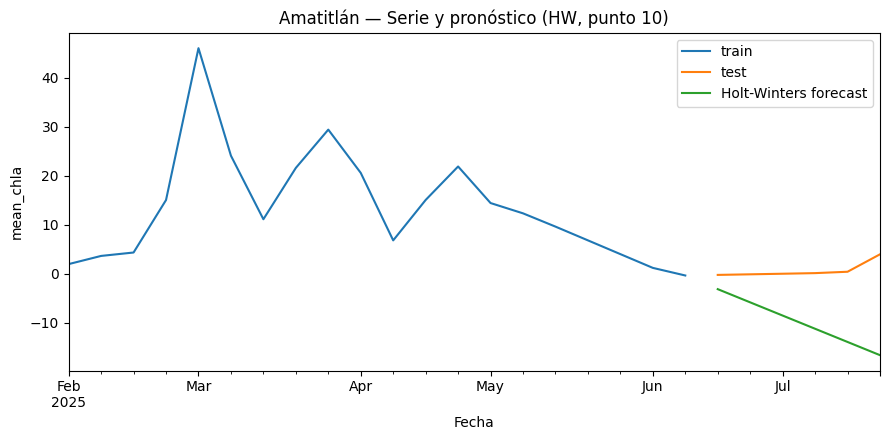

{'lake': 'Atitlán', 'metrics': {'naive': {'MAE': 1.2645238712960143, 'RMSE': 1.8360581138564915, 'sMAPE_%': 51.50592102166125}, 'mov_avg': {'MAE': 1.3020069852316387, 'RMSE': 1.7884655711944666, 'sMAPE_%': 52.962112695266526}, 'holt_winters': {'MAE': 1.1929551359724062, 'RMSE': 1.3482276165872, 'sMAPE_%': 51.19818885508608}}}
{'lake': 'Amatitlán', 'metrics': {'naive': {'MAE': 1.0490732552531161, 'RMSE': 1.8144386199173097, 'sMAPE_%': 154.40610284755658}, 'mov_avg': {'MAE': 1.7088643683926055, 'RMSE': 1.7449363818929624, 'sMAPE_%': 163.0696276345998}, 'holt_winters': {'MAE': 10.582605135885984, 'RMSE': 12.067547598713245, 'sMAPE_%': 193.65351169489026}}}


In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from math import sqrt
from dataclasses import dataclass
from typing import Dict, Tuple

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ---------- Métricas ----------
def mae(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return float(sqrt(np.mean((y_true - y_pred) ** 2)))

def smape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom[denom == 0] = 1e-9
    return float(100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom))

# ---------- Split temporal ----------
def time_split(s: pd.Series, test_points: int = 6) -> Tuple[pd.Series, pd.Series]:
    """Reserva los últimos 'test_points' para test (por defecto 6 semanas)."""
    s = s.dropna()
    n = len(s)
    k = min(max(4, test_points), max(1, n // 3)) 
    train = s.iloc[:-k]
    test  = s.iloc[-k:]
    return train, test

# ---------- Baselines ----------
def naive_forecast(train: pd.Series, steps: int) -> np.ndarray:
    last = train.iloc[-1]
    return np.full(steps, float(last), dtype=float)

def moving_average_forecast(train: pd.Series, steps: int, window: int = 3) -> np.ndarray:
    ma = train.rolling(window=window, min_periods=max(1, window//2)).mean().iloc[-1]
    if np.isnan(ma):
        ma = train.iloc[-1]
    return np.full(steps, float(ma), dtype=float)

# ---------- Holt-Winters (sin estacionalidad) ----------
def holt_winters_forecast(train: pd.Series, steps: int, trend: str = "add") -> np.ndarray:
    """
    Exponential Smoothing con tendencia aditiva (Holt). Si no converge,
    cae a suavización simple (sin tendencia).
    """
    try:
        model = ExponentialSmoothing(train.astype(float), trend=trend, seasonal=None)
        res = model.fit(optimized=True, use_brute=True)
        fc = res.forecast(steps)
        return np.asarray(fc, dtype=float)
    except Exception:
        # Fallback: SES
        model = ExponentialSmoothing(train.astype(float), trend=None, seasonal=None)
        res = model.fit(optimized=True, use_brute=True)
        fc = res.forecast(steps)
        return np.asarray(fc, dtype=float)

# ---------- Pipeline principal ----------
def run_ts_pipeline_hw(df: pd.DataFrame,
                       lake_name: str,
                       date_col: str = "date",
                       value_col: str = "mean_chla",
                       test_points: int = 6,
                       ma_window: int = 3,
                       plot: bool = True,
                       verbose: bool = True) -> Dict[str, Dict[str, float]]:

    s = (df[[date_col, value_col]]
         .assign(**{date_col: pd.to_datetime(df[date_col])})
         .set_index(date_col)
         .sort_index()[value_col]
         .astype(float))

    train, test = time_split(s, test_points=test_points)
    steps = len(test)

    # Modelos
    y_hat_naive = naive_forecast(train, steps)
    y_hat_ma    = moving_average_forecast(train, steps, window=ma_window)
    y_hat_hw    = holt_winters_forecast(train, steps, trend="add")

    # Métricas
    metrics = {}
    for name, yhat in [("naive", y_hat_naive), ("mov_avg", y_hat_ma), ("holt_winters", y_hat_hw)]:
        metrics[name] = {
            "MAE":  mae(test.values, yhat),
            "RMSE": rmse(test.values, yhat),
            "sMAPE_%": smape(test.values, yhat)
        }

    if verbose:
        print(f"[{lake_name}] puntos: train={len(train)}  test={len(test)}  (ventana MA={ma_window})")
        for k, v in metrics.items():
            print(f"  {k:12s} -> MAE={v['MAE']:.3f}  RMSE={v['RMSE']:.3f}  sMAPE={v['sMAPE_%']:.2f}%")

    if plot:
        plt.figure(figsize=(9,4.5))
        train.plot(label="train")
        test.plot(label="test")
        pd.Series(y_hat_hw, index=test.index).plot(label="Holt-Winters forecast")
        plt.title(f"{lake_name} — Serie y pronóstico (HW, punto 10)")
        plt.xlabel("Fecha"); plt.ylabel(value_col)
        plt.legend(); plt.tight_layout(); plt.show()

    return {"lake": lake_name, "metrics": metrics}

# ---------- Ejecución con series ts_ati / ts_ama ----------
ts_ati.name = "mean_chla"; ts_ama.name = "mean_chla"
df_ati = ts_ati.reset_index().rename(columns={"index":"date"})
df_ama = ts_ama.reset_index().rename(columns={"index":"date"})

r1 = run_ts_pipeline_hw(df_ati, "Atitlán",   test_points=6, ma_window=3)
r2 = run_ts_pipeline_hw(df_ama, "Amatitlán", test_points=6, ma_window=3)

print(r1); print(r2)


En el caso de la serie temporal del lago Atitlán, el modelo de Holt-Winters lineal mostró un desempeño superior frente a las aproximaciones más sencillas como el naïve y la media móvil. A pesar de contar únicamente con 23 observaciones, el algoritmo logró capturar una ligera tendencia descendente en los niveles de clorofila-a, reduciendo los errores en comparación con las referencias básicas.

Por otro lado, en el lago Amatitlán los resultados fueron diferentes. Allí, el comportamiento mucho más volátil de la serie hizo que Holt-Winters perdiera capacidad de generalización, llegando incluso a producir pronósticos lineales poco realistas que aumentaron errores. En contraste, el modelo naïve —a pesar de su simplicidad— se mostró más estable y con métricas de error considerablemente mejores.

In [ ]:

# PyTorch+DirectML para Windows 10/11; si no hay DML disponible, se usará CPU.
# SI USAN NORMALMENTE PYTHON 3.13, HAGAN ENTORNO VIRTUAL
# ONNX Runtime DirectML es opcional 
#!pip install -q torch-directml scikit-learn onnx onnxruntime-directml


In [ ]:
import torch_directml
device = torch_directml.device()
print(device)

# SI SALE privateuseone:0 ESTA BIEN

In [25]:
import torch
def get_device():
    if torch.cuda.is_available():
        print("[device] CUDA:", torch.cuda.get_device_name(0))
        return torch.device("cuda")
    print("[device] CPU")
    return torch.device("cpu")

device = get_device()


[device] CUDA: NVIDIA GeForce RTX 4060 Laptop GPU


In [26]:
# ============================
# Utilidades para INCISO 11 
# ============================
import os, re, glob
import numpy as np
import rasterio

BASE_DIR = "../data"
IMG_ATI   = os.path.join(BASE_DIR, "imgsAti")
IMG_AMATI = os.path.join(BASE_DIR, "imgsAmati")

def list_stacks_s2(lake_tag):
    """Devuelve los openEO_*.tif multibanda por lago."""
    folder = IMG_ATI if lake_tag=="Atitlan" else IMG_AMATI
    files = sorted(glob.glob(os.path.join(folder, "openEO_*.tif")))
    return files

def _safe_div(num, den, eps=1e-6):
    den_ok = np.where(np.abs(den) > eps, den, np.nan)
    return num / den_ok

def read_s2_stack(path):
    """
    Lee un stack Sentinel-2 (orden esperado: B02,B03,B04,B05,B07,B08,B8A,B11,B12)
    y normaliza 0..1 si hace falta.
    Devuelve: (B02..B12), transform, crs
    """
    with rasterio.open(path) as src:
        arr = src.read().astype(np.float32)  # shape = (count, H, W)
        transform, crs = src.transform, src.crs
        nodata = src.nodata

    if nodata is not None:
        arr = np.where(arr == nodata, np.nan, arr)

    p99 = np.nanpercentile(arr, 99)
    if p99 > 1.5:   # heurística: si parece 0..10000, normaliza
        arr = arr / 10000.0

    arr = np.clip(arr, 0.0, 1.2) 

    if arr.shape[0] < 9:
        raise ValueError(f"{os.path.basename(path)} no tiene 9 bandas esperadas (tiene {arr.shape[0]}).")

    B02, B03, B04, B05, B07, B08, B8A, B11, B12 = arr[:9]
    return (B02, B03, B04, B05, B07, B08, B8A, B11, B12), transform, crs

def compute_indices_arrays(B02, B03, B04, B05, B07, B08, B8A, B11, B12,
                           mndwi_thr=0.42, ndwi_thr=0.40, filter_UABS=True):
    # Índices con divisiones seguras
    ndvi        = _safe_div(B08 - B04, B08 + B04)
    mndwi       = _safe_div(B03 - B11, B03 + B11)
    ndwi        = _safe_div(B03 - B08, B03 + B08)
    ndwi_leaves = _safe_div(B08 - B11, B08 + B11)

    aweish  = B02 + 2.5*B03 - 1.5*(B08 + B11) - 0.25*B12
    aweinsh = 4*(B03 - B11) - (0.25*B08 + 2.75*B11)
    dbsi    = _safe_div(B11 - B03, B11 + B03) - ndvi

    # Water mask (ws)
    ws = (
        (mndwi > mndwi_thr) |
        (ndwi  > ndwi_thr)  |
        (aweinsh > 0.1879)  |
        (aweish  > 0.1112)  |
        (ndvi < -0.2)       |
        (ndwi_leaves > 1)
    )
    ws = np.where(np.isnan(ws), False, ws)
    if filter_UABS:
        ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))

    # FAI y NDCI
    FAI  = B8A - B04 - (B07 - B04) * (783 - 665) / (865 - 665 + 1e-6)
    NDCI = _safe_div(B05 - B04, B05 + B04)

    # Proxy clorofila-a
    chl = 826.57*(NDCI**3) - 176.43*(NDCI**2) + 19*NDCI + 4.071

    # Aplicar máscara de agua + saneo
    chl = np.where(ws, chl, np.nan)
    chl = np.where(np.isfinite(chl), chl, np.nan)
    chl = np.where((chl < -5) | (chl > 300), np.nan, chl)

    return ws.astype(np.uint8), FAI, NDCI, chl

# Sanity check (cuenta stacks por lago)
for _lake in ["Amatitlan", "Atitlan"]:
    _files = list_stacks_s2(_lake)
    print(f"[{_lake}] stacks S2 encontrados: {len(_files)}")


[Amatitlan] stacks S2 encontrados: 23
[Atitlan] stacks S2 encontrados: 23


### Modelo MLP 

In [27]:
import os, glob, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio
import torch
import torch.nn as nn
import torch.utils.data as data
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", category=RuntimeWarning)


try:
    list_stacks_s2
    read_s2_stack
    compute_indices_arrays
except NameError:
    raise RuntimeError("Faltan utilidades previas del notebook (list_rasters, read_s2_stack, compute_indices_arrays). Ejecuta las celdas anteriores.")

# ────────────────────────────────────────────────────────────────────────────────
# Configuración
# ────────────────────────────────────────────────────────────────────────────────
LAKES = ["Atitlan", "Amatitlan"]  
MAX_SAMPLES_PER_IMAGE = 4000       # submuestreo estratificado por imagen
TEST_SIZE_DATES = 0.25             # último ~25% de fechas como test
THRESHOLD_METHOD = "p75"           # umbral para presencia (percentil 75)
MIN_WATER_MASK = 0.02              # descartar imágenes con <2% de pixeles de agua
RANDOM_STATE = 42

# ────────────────────────────────────────────────────────────────────────────────
# Ensamblado de dataset por lago
# ────────────────────────────────────────────────────────────────────────────────
def presence_threshold(arr, method="p75"):
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return np.nan
    if method == "p90":
        return float(np.nanpercentile(arr, 90))
    return float(np.nanpercentile(arr, 75))

def build_pixel_dataset_for_lake(lake_tag: str):
    """
    Devuelve X, y, fechas: features y etiquetas binaria por píxel,
    y una lista paralela con la fecha de cada muestra para split temporal.
    """
    files = list_stacks_s2(lake_tag)
    if not files:
        raise RuntimeError(f"No hay rásters para {lake_tag}. Ejecuta el orquestador del punto 9.")

    # Primero: calcular umbral a partir de chla por-píxel 
    chla_all = []
    per_image = []  
    for tif in files:
        (B02,B03,B04,B05,B07,B08,B8A,B11,B12), transform, crs = read_s2_stack(tif)
        ws, FAI, NDCI, chl = compute_indices_arrays(B02,B03,B04,B05,B07,B08,B8A,B11,B12)
        finite = np.isfinite(chl) & (ws.astype(bool))
        coverage = float(np.mean(finite)) if finite.size else 0.0
        if coverage < MIN_WATER_MASK:
            continue
        per_image.append((tif, (B02,B03,B04,B05,B07,B08,B8A,B11,B12), ws, FAI, NDCI, chl, finite))
        chla_all.append(chl[finite])
    if not per_image:
        raise RuntimeError(f"{lake_tag}: ninguna imagen con cobertura de agua >= {MIN_WATER_MASK*100:.0f}%")

    chla_all = np.concatenate(chla_all)
    thr = presence_threshold(chla_all, method=THRESHOLD_METHOD)
    if not np.isfinite(thr):
        raise RuntimeError(f"{lake_tag}: umbral de presencia no definido (sin datos válidos).")

    X_list, y_list, dates_list = [], [], []
    rng = np.random.default_rng(RANDOM_STATE)
    for (tif, bands, ws, FAI, NDCI, chl, finite) in per_image:
        date_tag = re.search(r"(20\d{2}-\d{2}-\d{2})", os.path.basename(tif))
        date_tag = date_tag.group(1) if date_tag else "unknown"

        B02,B03,B04,B05,B07,B08,B8A,B11,B12 = bands

        # Índices adicionales (en arrays)
        NDVI = (B08 - B04) / (B08 + B04 + 1e-6)
        NDWI = (B03 - B08) / (B03 + B08 + 1e-6)

        mask = finite & np.isfinite(FAI) & np.isfinite(NDCI) & np.isfinite(NDVI) & np.isfinite(NDWI)
        if not np.any(mask):
            continue

        # Submuestrear por imagen para equilibrar tamaño
        idx = np.where(mask.ravel())[0]
        if idx.size == 0:
            continue
        take = min(MAX_SAMPLES_PER_IMAGE, idx.size)
        choice = rng.choice(idx, size=take, replace=False)
        # Recuperar coordenadas 2D
        H, W = mask.shape
        rr, cc = np.divmod(choice, W)

        # Features 
        feats = np.stack([
            NDVI[rr, cc],
            NDWI[rr, cc],
            FAI[rr, cc],
            NDCI[rr, cc],
            B03[rr, cc],  # Green
            B04[rr, cc],  # Red
            B08[rr, cc],  # NIR
            B11[rr, cc],  # SWIR1
        ], axis=1)

        labels = (chl[rr, cc] >= thr).astype(np.float32)

        X_list.append(feats.astype(np.float32))
        y_list.append(labels)
        dates_list.extend([date_tag]*take)

    X = np.concatenate(X_list, axis=0) if X_list else np.empty((0,8), dtype=np.float32)
    y = np.concatenate(y_list, axis=0) if y_list else np.empty((0,), dtype=np.float32)
    dates = np.array(dates_list)

    return X, y, dates, thr

# ────────────────────────────────────────────────────────────────────────────────
# Modelo (MLP) en PyTorch con DirectML
# ────────────────────────────────────────────────────────────────────────────────
def get_dml_device():
    try:
        import torch_directml
        return torch_directml.device()
    except Exception:
        return torch.device("cpu")

class MLP(nn.Module):
    def __init__(self, in_dim=8, hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1) 
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

def train_one_lake(lake_tag: str):
    print(f"\n=== {lake_tag} ===")
    X, y, dates, thr = build_pixel_dataset_for_lake(lake_tag)
    print(f"Dataset: X={X.shape}, y={y.shape}, umbral presencia (chla) = {thr:.3f}")

    # Split temporal por fechas
    unique_dates = np.array(sorted(np.unique(dates)))
    n_test_dates = max(1, int(np.ceil(len(unique_dates) * TEST_SIZE_DATES)))
    test_dates = set(unique_dates[-n_test_dates:])
    test_mask = np.isin(dates, list(test_dates))
    train_mask = ~test_mask

    X_train, y_train = X[train_mask], y[train_mask]
    X_test,  y_test  = X[test_mask],  y[test_mask]

    # Estandarización con stats del train 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # Tensores
    device = get_dml_device()
    Xtr = torch.tensor(X_train, dtype=torch.float32, device=device)
    ytr = torch.tensor(y_train, dtype=torch.float32, device=device)
    Xte = torch.tensor(X_test,  dtype=torch.float32, device=device)
    yte = torch.tensor(y_test,  dtype=torch.float32, device=device)

    # Modelo
    model = MLP(in_dim=X.shape[1], hidden=64, dropout=0.1).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    # Entrenamiento
    epochs = 20
    batch = 2048
    model.train()
    for ep in range(1, epochs+1):
        # mini-batching manual 
        perm = torch.randperm(Xtr.size(0), device=device)
        epoch_loss = 0.0
        for i in range(0, Xtr.size(0), batch):
            idx = perm[i:i+batch]
            logits = model(Xtr[idx])
            loss = loss_fn(logits, ytr[idx])
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * idx.numel()
        epoch_loss /= Xtr.size(0)
        if ep % 2 == 0 or ep == 1:
            print(f"  epoch {ep:02d}  loss={epoch_loss:.4f}")

    # Evaluación
    model.eval()
    with torch.no_grad():
        logits = model(Xte)
        probs  = torch.sigmoid(logits).detach().cpu().numpy()
    y_true = y_test.astype(int)
    y_pred = (probs >= 0.5).astype(int)

    # Métricas
    try:
        roc = roc_auc_score(y_true, probs)
        pr  = average_precision_score(y_true, probs)
    except Exception:
        roc, pr = np.nan, np.nan
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)

    print(f"Test metrics  ({lake_tag})")
    print(f"  ROC-AUC = {roc:.3f}   PR-AUC = {pr:.3f}   F1 = {f1:.3f}   Precision = {p:.3f}   Recall = {r:.3f}")
    return {
        "lake": lake_tag,
        "roc_auc": float(roc), "pr_auc": float(pr),
        "f1": float(f1), "precision": float(p), "recall": float(r),
        "threshold_chla": float(thr),
        "n_train": int(X_train.shape[0]), "n_test": int(X_test.shape[0]),
        "test_dates": sorted(list(test_dates))
    }, scaler, model

results = []
models = {}
for lake in LAKES:
    res, scaler, model = train_one_lake(lake)
    results.append(res)
    models[lake] = {"scaler": scaler, "model": model}

# Tabla de resultados
res_df = pd.DataFrame(results)
display(res_df)

# ────────────────────────────────────────────────────────────────────────────────
# Guardar modelos y scaler a disco + exportar a ONNX para inferencia
# ────────────────────────────────────────────────────────────────────────────────
OUT = Path("../data/models_directml"); OUT.mkdir(parents=True, exist_ok=True)

for lake in LAKES:
    torch.save(models[lake]["model"].state_dict(), OUT/f"mlp_{lake}.pt")
    # Guardar scaler
    import joblib
    joblib.dump(models[lake]["scaler"], OUT/f"scaler_{lake}.pkl")

    # Exportar ONNX
    dummy = torch.randn(1, 8, dtype=torch.float32)
    torch.onnx.export(models[lake]["model"].cpu(), dummy, OUT/f"mlp_{lake}.onnx",
                      input_names=["x"], output_names=["logits"], opset_version=17)
print(f"Modelos guardados en: {OUT.resolve()}")



=== Atitlan ===
Dataset: X=(48000, 8), y=(48000,), umbral presencia (chla) = 4.143
  epoch 01  loss=0.6195
  epoch 02  loss=0.4372
  epoch 04  loss=0.1892
  epoch 06  loss=0.0948
  epoch 08  loss=0.0640
  epoch 10  loss=0.0520
  epoch 12  loss=0.0416
  epoch 14  loss=0.0345
  epoch 16  loss=0.0290
  epoch 18  loss=0.0261
  epoch 20  loss=0.0230
Test metrics  (Atitlan)
  ROC-AUC = 1.000   PR-AUC = 1.000   F1 = 0.996   Precision = 1.000   Recall = 0.993

=== Amatitlan ===
Dataset: X=(28000, 8), y=(28000,), umbral presencia (chla) = 48.051
  epoch 01  loss=0.6565
  epoch 02  loss=0.5245
  epoch 04  loss=0.3164
  epoch 06  loss=0.1975
  epoch 08  loss=0.1229
  epoch 10  loss=0.0859
  epoch 12  loss=0.0654
  epoch 14  loss=0.0535
  epoch 16  loss=0.0463
  epoch 18  loss=0.0409
  epoch 20  loss=0.0358
Test metrics  (Amatitlan)
  ROC-AUC = 1.000   PR-AUC = 0.997   F1 = 0.966   Precision = 0.979   Recall = 0.953


,lake,roc_auc,pr_auc,f1,precision,recall,threshold_chla,n_train,n_test,test_dates
0,Atitlan,0.999996,0.999991,0.996193,0.999736,0.992674,4.142847,36000,12000,"[2025-04-18, 2025-04-28, 2025-05-13]"
1,Amatitlan,0.999857,0.996688,0.965723,0.978852,0.952941,48.051243,20000,8000,"[2025-05-03, 2025-05-13]"


Modelos guardados en: C:\Users\Andy Ortega\Progras\Data Science\Lab4_DS\data\models_directml


### Modelo híbrido con features temporales

##### Features temporales sin fuga (walk-forward)

In [28]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

DATA = Path("../data")
summary_clean = pd.read_csv(DATA/"summary_point5_clean.csv", parse_dates=["date"])

def _series_lake(summary_df, lake, start="2025-02-01", end="2025-07-31"):
    g = (summary_df[summary_df["lake"]==lake]
         .sort_values("date")[["date","mean_chla"]]
         .dropna())
    s = (g.set_index("date")["mean_chla"]
          .reindex(pd.date_range(start, end, freq="D"))
          .interpolate("time"))
    return s

def _hw_forecast(train: pd.Series, steps:int=1):
    try:
        m = ExponentialSmoothing(train.astype(float), trend="add", seasonal=None)
        r = m.fit(optimized=True, use_brute=True)
        fc = r.forecast(steps)
        return float(fc.iloc[-1])
    except Exception:
        m = ExponentialSmoothing(train.astype(float), trend=None, seasonal=None)
        r = m.fit(optimized=True, use_brute=True)
        fc = r.forecast(steps)
        return float(fc.iloc[-1])

def _safe_mean(x):
    x = pd.Series(x).dropna()
    return float(x.mean()) if len(x) else np.nan

def build_ts_feature_map(summary_df, lake, start="2025-02-01", end="2025-07-31"):
    """
    Devuelve un dict {YYYY-MM-DD: {ts_pred, ts_lag7, ts_lag14}} para cada fecha del período.
    - ts_pred: pronóstico 1-paso adelante con ventana expandida (solo pasado).
    - ts_lag7, ts_lag14: rezagos basados en promedio móvil retrospectivo.
    """
    s = _series_lake(summary_df, lake, start=start, end=end)
    dates = s.index
    feat = {}
    for d in dates:
        past = s.loc[:d - pd.Timedelta(days=1)].dropna()
        if len(past) >= 5:
            pred = _hw_forecast(past, steps=1)
        else:
            pred = _safe_mean(past)
        lag7  = _safe_mean(past.tail(7))
        lag14 = _safe_mean(past.tail(14))
        feat[d.strftime("%Y-%m-%d")] = {
            "ts_pred": float(pred) if np.isfinite(pred) else float(s.mean()),
            "ts_lag7": float(lag7)  if np.isfinite(lag7) else float(s.mean()),
            "ts_lag14": float(lag14) if np.isfinite(lag14) else float(s.mean())
        }
    return feat

TS_FEATS = {
    "Atitlan":    build_ts_feature_map(summary_clean, "Atitlan",    start="2025-02-01", end="2025-07-31"),
    "Amatitlan":  build_ts_feature_map(summary_clean, "Amatitlan",  start="2025-02-01", end="2025-07-31"),
}

print("TS_FEATS keys (Atitlan):", list(TS_FEATS["Atitlan"])[:5], "...")
print("TS_FEATS keys (Amatitlan):", list(TS_FEATS["Amatitlan"])[:5], "...")


TS_FEATS keys (Atitlan): ['2025-02-01', '2025-02-02', '2025-02-03', '2025-02-04', '2025-02-05'] ...
TS_FEATS keys (Amatitlan): ['2025-02-01', '2025-02-02', '2025-02-03', '2025-02-04', '2025-02-05'] ...


##### Dataset híbrido (píxel) con features temporales

In [34]:
def build_hybrid_pixel_dataset(lake_tag: str,
                               ts_feature_map: dict,
                               max_samples_per_image: int = 4000,
                               min_water_mask: float = 0.02,
                               thr_method: str = "p75",
                               seed: int = 42):
    """
    Devuelve:
      X_base (8 feats espectrales/índices),
      X_ts (3 feats temporales),
      y (binaria),
      dates (vector de fechas por muestra),
      thr_chla (umbral usado)
    """
    rng = np.random.default_rng(seed)
    files = list_stacks_s2(lake_tag)
    if not files:
        raise RuntimeError(f"No hay stacks openEO_*.tif para {lake_tag}.")

    # 1) calcular umbral con TODAS las imágenes válidas (sin fuga, es solo para etiquetar)
    chla_all, per_image = [], []
    for tif in files:
        (B02,B03,B04,B05,B07,B08,B8A,B11,B12), _, _ = read_s2_stack(tif)
        ws, FAI, NDCI, chl = compute_indices_arrays(B02,B03,B04,B05,B07,B08,B8A,B11,B12)
        finite = np.isfinite(chl) & ws.astype(bool)
        coverage = float(np.mean(finite)) if finite.size else 0.0
        if coverage < min_water_mask:
            continue
        per_image.append((tif, (B02,B03,B04,B05,B07,B08,B8A,B11,B12), ws, FAI, NDCI, chl, finite))
        chla_all.append(chl[finite])
    if not per_image:
        raise RuntimeError(f"{lake_tag}: sin imágenes con cobertura de agua >= {min_water_mask*100:.0f}%.")

    chla_all = np.concatenate(chla_all)
    thr = np.nanpercentile(chla_all, 90 if thr_method=="p90" else 75)

    Xb_list, Xt_list, y_list, d_list = [], [], [], []
    for (tif, bands, ws, FAI, NDCI, chl, finite) in per_image:
        # fecha
        m = re.search(r"(20\d{2}-\d{2}-\d{2})", os.path.basename(tif))
        date_tag = m.group(1) if m else "unknown"

        B02,B03,B04,B05,B07,B08,B8A,B11,B12 = bands
        NDVI = (B08 - B04) / (B08 + B04 + 1e-6)
        NDWI = (B03 - B08) / (B03 + B08 + 1e-6)

        mask = finite & np.isfinite(FAI) & np.isfinite(NDCI) & np.isfinite(NDVI) & np.isfinite(NDWI)
        idx = np.where(mask.ravel())[0]
        if idx.size == 0:
            continue

        take = min(max_samples_per_image, idx.size)
        choice = rng.choice(idx, size=take, replace=False)
        H, W = mask.shape
        rr, cc = np.divmod(choice, W)

        # 8 features base
        X_base = np.stack([
            NDVI[rr, cc], NDWI[rr, cc], FAI[rr, cc], NDCI[rr, cc],
            B03[rr, cc], B04[rr, cc], B08[rr, cc], B11[rr, cc]
        ], axis=1).astype(np.float32)

        # 3 features temporales
        tsf = ts_feature_map.get(date_tag)
        if tsf is None:
            # si no está la fecha exacta por alguna razón, usa el valor medio del mapa
            tsf = pd.DataFrame(ts_feature_map).T.mean().to_dict()
        X_ts = np.stack([
            np.full(take, tsf["ts_pred"], dtype=np.float32),
            np.full(take, tsf["ts_lag7"], dtype=np.float32),
            np.full(take, tsf["ts_lag14"], dtype=np.float32),
        ], axis=1)

        # etiqueta
        y = (chl[rr, cc] >= thr).astype(np.float32)

        Xb_list.append(X_base)
        Xt_list.append(X_ts)
        y_list.append(y)
        d_list.extend([date_tag]*take)

    X_base = np.concatenate(Xb_list, axis=0) if Xb_list else np.empty((0,8), dtype=np.float32)
    X_ts   = np.concatenate(Xt_list, axis=0) if Xt_list else np.empty((0,3), dtype=np.float32)
    y      = np.concatenate(y_list,  axis=0) if y_list  else np.empty((0,),  dtype=np.float32)
    dates  = np.array(d_list)

    return X_base, X_ts, y, dates, float(thr)


##### Entrenamiento y comparación (sin vs con features temporales)

In [35]:
# Utilidades requeridas por el híbrido
import os, re, glob
import numpy as np
import rasterio

# list_stacks_s2 (buscar los openEO_*.tif por lago)
try:
    list_stacks_s2
except NameError:
    BASE_DIR = "../data"
    IMG_ATI   = os.path.join(BASE_DIR, "imgsAti")
    IMG_AMATI = os.path.join(BASE_DIR, "imgsAmati")
    def list_stacks_s2(lake_tag):
        folder = IMG_ATI if lake_tag=="Atitlan" else IMG_AMATI
        return sorted(glob.glob(os.path.join(folder, "openEO_*.tif")))
    print("[OK] list_stacks_s2 definido.")

# read_s2_stack (lee stack S2 y normaliza si viene en 0..10000)
try:
    read_s2_stack
except NameError:
    def read_s2_stack(path):
        with rasterio.open(path) as src:
            arr = src.read().astype(np.float32)
            transform, crs = src.transform, src.crs
            nodata = src.nodata
        if nodata is not None:
            arr = np.where(arr == nodata, np.nan, arr)
        p99 = np.nanpercentile(arr, 99)
        if p99 > 1.5:  # típico 0..10000
            arr = arr / 10000.0
        arr = np.clip(arr, 0.0, 1.2)
        if arr.shape[0] < 9:
            raise ValueError(f"{os.path.basename(path)} no tiene 9 bandas esperadas (tiene {arr.shape[0]}).")
        B02, B03, B04, B05, B07, B08, B8A, B11, B12 = arr[:9]
        return (B02, B03, B04, B05, B07, B08, B8A, B11, B12), transform, crs
    print("[OK] read_s2_stack definido.")

# compute_indices_arrays (máscara de agua y clorofila proxy)
try:
    compute_indices_arrays
except NameError:
    def _safe_div(num, den, eps=1e-6):
        den_ok = np.where(np.abs(den) > eps, den, np.nan)
        return num / den_ok
    def compute_indices_arrays(B02, B03, B04, B05, B07, B08, B8A, B11, B12,
                               mndwi_thr=0.42, ndwi_thr=0.40, filter_UABS=True):
        ndvi        = _safe_div(B08 - B04, B08 + B04)
        mndwi       = _safe_div(B03 - B11, B03 + B11)
        ndwi        = _safe_div(B03 - B08, B03 + B08)
        ndwi_leaves = _safe_div(B08 - B11, B08 + B11)

        aweish  = B02 + 2.5*B03 - 1.5*(B08 + B11) - 0.25*B12
        aweinsh = 4*(B03 - B11) - (0.25*B08 + 2.75*B11)
        dbsi    = _safe_div(B11 - B03, B11 + B03) - ndvi

        ws = ((mndwi > mndwi_thr) | (ndwi > ndwi_thr) |
              (aweinsh > 0.1879) | (aweish > 0.1112) |
              (ndvi < -0.2) | (ndwi_leaves > 1))
        ws = np.where(np.isnan(ws), False, ws)
        if filter_UABS:
            ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))

        FAI  = B8A - B04 - (B07 - B04) * (783 - 665) / (865 - 665 + 1e-6)
        NDCI = _safe_div(B05 - B04, B05 + B04)

        chl = 826.57*(NDCI**3) - 176.43*(NDCI**2) + 19*NDCI + 4.071
        chl = np.where(ws, chl, np.nan)
        chl = np.where(np.isfinite(chl), chl, np.nan)
        chl = np.where((chl < -5) | (chl > 300), np.nan, chl)
        return ws.astype(np.uint8), FAI, NDCI, chl
    print("[OK] compute_indices_arrays definido.")

In [36]:
import torch, numpy as np
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support

def make_loss_with_pos_weight(y_train, device):
    pos = float(np.sum(y_train))
    neg = float(len(y_train) - pos)
    w = (neg / max(pos, 1.0))
    return nn.BCEWithLogitsLoss(pos_weight=torch.tensor([w], device=device))

# Selección de dispositivo y aceleradores de NVIDIA
def get_cuda_device():
    if torch.cuda.is_available():
        print("[CUDA] usando:", torch.cuda.get_device_name(0))
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        try:
            torch.set_float32_matmul_precision("high")
        except Exception:
            pass
        return torch.device("cuda"), True
    print("[CUDA] no disponible; usando CPU")
    return torch.device("cpu"), False

device, USE_AMP = get_cuda_device()

# Entrenador genérico para el MLP con AMP
def fit_mlp_cuda(X_train, y_train, in_dim, hidden=64, dropout=0.1, epochs=12, batch=4096, loss_fn=None):
    model = MLP(in_dim=in_dim, hidden=hidden, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-3)

    # si no te pasan una loss, usa BCE estándar
    if loss_fn is None:
        loss_fn = nn.BCEWithLogitsLoss()

    Xtr = torch.tensor(X_train, dtype=torch.float32, device=device)
    ytr = torch.tensor(y_train, dtype=torch.float32, device=device)
    n = Xtr.size(0)

    # API nueva de AMP (evita FutureWarnings)
    scaler = torch.amp.GradScaler('cuda') if USE_AMP else None

    for ep in range(1, epochs + 1):
        idx = torch.randperm(n, device=device)
        running = 0.0
        for i in range(0, n, batch):
            b = idx[i:i+batch]
            opt.zero_grad(set_to_none=True)
            # autocast con API nueva
            with torch.amp.autocast('cuda', enabled=USE_AMP):
                logits = model(Xtr[b])
                loss = loss_fn(logits, ytr[b])
            # backward/step con o sin AMP
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()
            running += loss.item() * b.numel()
        if ep % 2 == 0 or ep == 1:
            print(f"  epoch {ep:02d}  loss={running/n:.4f}")
    return model

# Split por fechas
def temporal_split_by_dates(dates: np.ndarray, test_frac: float = 0.25):
    uniq = np.array(sorted(np.unique(dates)))
    n_test = max(1, int(np.ceil(len(uniq)*test_frac)))
    test_dates = set(uniq[-n_test:])
    test_mask = np.isin(dates, list(test_dates))
    return test_mask, sorted(list(test_dates))

# Entrenamiento/evaluación (baseline vs híbrido) usando CUDA
def train_eval_hybrid(lake_tag: str, ts_feats_map: dict,
                      epochs=12, batch=4096, hidden=64, dropout=0.1):
    print(f"\n=== HÍBRIDO {lake_tag} ===")
    Xb, Xt, y, dates, thr = build_hybrid_pixel_dataset(
        lake_tag, ts_feats_map,
        max_samples_per_image=3000,   # <- baja si te quedas sin VRAM
        min_water_mask=0.02, thr_method="p75", seed=42
    )
    print(f"Base: {Xb.shape}   TS: {Xt.shape}   y: {y.shape}   thr={thr:.3f}")

    test_mask, test_dates = temporal_split_by_dates(dates, test_frac=0.25)
    tr, te = ~test_mask, test_mask
    yte = y[te].astype(int)

    # baseline (solo 8 features)
    scaler_b = StandardScaler()
    Xb_tr = scaler_b.fit_transform(Xb[tr]); Xb_te = scaler_b.transform(Xb[te])

    loss_b = make_loss_with_pos_weight(y[tr], device)

    model_b = fit_mlp_cuda(Xb_tr, y[tr], in_dim=Xb_tr.shape[1],
                       hidden=hidden, dropout=dropout, epochs=epochs, batch=batch,
                       loss_fn=loss_b)

    with torch.no_grad():
        Xte_t = torch.tensor(Xb_te, dtype=torch.float32, device=device)
        p_b = torch.sigmoid(model_b(Xte_t)).detach().cpu().numpy()
    yhat_b = (p_b >= 0.5).astype(int)
    roc_b = roc_auc_score(yte, p_b) if len(np.unique(yte))>1 else np.nan
    pr_b  = average_precision_score(yte, p_b) if len(np.unique(yte))>1 else np.nan
    p_bi, r_bi, f1_b, _ = precision_recall_fscore_support(yte, yhat_b, average="binary", zero_division=0)

    # híbrido (8 + 3 temporales)
    X_h_tr = np.hstack([Xb[tr], Xt[tr]])
    X_h_te = np.hstack([Xb[te], Xt[te]])
    scaler_h = StandardScaler()
    X_h_tr = scaler_h.fit_transform(X_h_tr); X_h_te = scaler_h.transform(X_h_te)

    loss_h = make_loss_with_pos_weight(y[tr], device)

    model_h = fit_mlp_cuda(X_h_tr, y[tr], in_dim=X_h_tr.shape[1],
                       hidden=hidden, dropout=dropout, epochs=epochs, batch=batch,
                       loss_fn=loss_h)

    with torch.no_grad():
        Xte_h = torch.tensor(X_h_te, dtype=torch.float32, device=device)
        p_h = torch.sigmoid(model_h(Xte_h)).detach().cpu().numpy()
    yhat_h = (p_h >= 0.5).astype(int)
    roc_h = roc_auc_score(yte, p_h) if len(np.unique(yte))>1 else np.nan
    pr_h  = average_precision_score(yte, p_h) if len(np.unique(yte))>1 else np.nan
    p_hi, r_hi, f1_h, _ = precision_recall_fscore_support(yte, yhat_h, average="binary", zero_division=0)

    res = pd.DataFrame([
        ["baseline(8 feats)", roc_b, pr_b, f1_b, p_bi, r_bi, len(yte), test_dates],
        ["híbrido(+3 TS)",   roc_h, pr_h, f1_h, p_hi, r_hi, len(yte), test_dates]
    ], columns=["modelo","ROC-AUC","PR-AUC","F1","Precision","Recall","n_test","test_dates"])

    # devolver también objetos útiles
    packs = {"baseline":{"scaler":scaler_b, "model":model_b},
             "hybrid":{"scaler":scaler_h, "model":model_h}}
    return res, packs, test_dates

[CUDA] usando: NVIDIA GeForce RTX 4060 Laptop GPU


In [37]:
res_ati, models_ati, td_ati = train_eval_hybrid("Atitlan",   TS_FEATS["Atitlan"],   epochs=12, batch=4096)
res_am,  models_am,  td_am  = train_eval_hybrid("Amatitlan", TS_FEATS["Amatitlan"], epochs=12, batch=4096)

print("\n=== Resultados Atitlán ==="); display(res_ati)
print("\n=== Resultados Amatitlán ==="); display(res_am)


=== HÍBRIDO Atitlan ===
Base: (36000, 8)   TS: (36000, 3)   y: (36000,)   thr=4.143
  epoch 01  loss=1.0000
  epoch 02  loss=0.9250
  epoch 04  loss=0.7652
  epoch 06  loss=0.5627
  epoch 08  loss=0.3886
  epoch 10  loss=0.2649
  epoch 12  loss=0.1909
  epoch 01  loss=0.9714
  epoch 02  loss=0.8912
  epoch 04  loss=0.7435
  epoch 06  loss=0.5677
  epoch 08  loss=0.4069
  epoch 10  loss=0.2884
  epoch 12  loss=0.2109

=== HÍBRIDO Amatitlan ===
Base: (21000, 8)   TS: (21000, 3)   y: (21000,)   thr=48.051
  epoch 01  loss=0.9260
  epoch 02  loss=0.8530
  epoch 04  loss=0.7011
  epoch 06  loss=0.5432
  epoch 08  loss=0.4208
  epoch 10  loss=0.3378
  epoch 12  loss=0.2687
  epoch 01  loss=0.9160
  epoch 02  loss=0.8434
  epoch 04  loss=0.6838
  epoch 06  loss=0.5174
  epoch 08  loss=0.3974
  epoch 10  loss=0.3249
  epoch 12  loss=0.2682

=== Resultados Atitlán ===


,modelo,ROC-AUC,PR-AUC,F1,Precision,Recall,n_test,test_dates
0,baseline(8 feats),0.997662,0.995227,0.947580,0.911992,0.986058,9000,"[2025-04-18, 2025-04-28, 2025-05-13]"
1,híbrido(+3 TS),0.996442,0.992961,0.922852,0.864051,0.990241,9000,"[2025-04-18, 2025-04-28, 2025-05-13]"



=== Resultados Amatitlán ===


,modelo,ROC-AUC,PR-AUC,F1,Precision,Recall,n_test,test_dates
0,baseline(8 feats),0.996139,0.917811,0.624187,0.453686,1.000000,6000,"[2025-05-03, 2025-05-13]"
1,híbrido(+3 TS),0.995611,0.917824,0.682796,0.962121,0.529167,6000,"[2025-05-03, 2025-05-13]"


Desarrollamos un modelo híbrido con features temporales, combinando las ocho variables espectrales obtenidas de imágenes Sentinel-2 con tres variables derivadas de la serie temporal de clorofila-a (pronóstico Holt-Winters a un paso y rezagos de 7 y 14 días). De esta manera, cada observación incluyó tanto información espacial como temporal, lo que nos permitió evaluar si la incorporación de series históricas podía mejorar las predicciones respecto al modelo baseline que solo usaba datos espectrales.

Los resultados mostraron diferencias según el lago. En Atitlán, el modelo baseline ya alcanzaba un rendimiento muy alto, por lo que el híbrido no generó mejoras significativas. En cambio, en Amatitlán, el baseline logró un recall muy elevado pero con baja precisión debido a falsos positivos. El modelo híbrido equilibró esta situación, aumentando la precisión aunque con una ligera reducción en recall, lo que lo hizo más confiable al emitir alertas. En síntesis, las features temporales fueron poco relevantes en un lago estable como Atitlán, pero aportaron valor en Amatitlán, donde la dinámica es más variable y los riesgos de falsas alarmas son mayores.